# Hit-Predict project: Predicting a song's popularity using Spotify data

## Problem Statement

Predicting a song's popularity is mutually beneficial for both the industry and its consumers. Record labels and streaming platforms are interested in which songs to promote and prioritize, and consumers want to discover songs they connect with and enjoy. This project therefore seeks to answer the question: **What factors most strongly influence a song's popularity, and how can they be leveraged to accurately predict it?**

This project focuses on predicting the popularity of songs from the streaming service Spotify based on audio features, artist information, and other relevant metadata. The goal is to build a model and that provides robust predictions on the popularity of songs. 

Predicting track popularity requires analyzing patterns in song attributes to understand its influences. Key features to consider include song characteristics like danceability, energy, loudness, and genre. 

The challenge with predicting popularity is that popularity distribution is heavily skewed; in other words, not many songs become hits. Particularly with streaming services, it is easy to upload your own songs which results in many tracks having zero popularity. This imbalanced distribution may introduce bias in training models if not handled appropriately.

To accompany our popularity prediction, we aim to create a recommendation system that takes a song a user enjoys, and suggests similar songs. As songs often have numerous overlapping characteristics, a challenge in this area is clearly defining what makes songs similar.

# to do: update table of contents

## Table of Contents
1. [Setup](#setup)
    - [Importing Libraries](#lib)
    - [Loading Data](#data)
2. [EDA](#eda)
3. [Baseline Models](#baseline)
    - [Regression Baseline Model](#sub1)
    - [Classification Baseline Model (using 5 levels)](#sub2)
        - [Decision Tree](#subclass1)
        - [Logistic Regression](#subclass2)
4. [Final Model Pipeline](#pipeline)
5. [Implementation Plan & Future Analysis](#future)

## 1. Setup
<a id="setup"></a>

### Importing Libraries
<a id="lib"></a>

In [46]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV,  StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from sklearn.metrics import r2_score
from scipy.stats import zscore
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

### Loading Data
<a id="data"></a>

Loading three dataframes, each of which encode the imbalanced data in different ways. We will explore this imbalance in our EDA and decide which encoding works best for our model in the baseline modelling section.

In [47]:
DATA_PATH_nothing = "../data/processed_spotify_songs.csv"
df_nothing = pd.read_csv(DATA_PATH_nothing)

DATA_PATH_0mean = "../data/0mean_data.csv"
df_0mean = pd.read_csv(DATA_PATH_0mean)

DATA_PATH_no0 = "../data/no0_data.csv"
df_no0 = pd.read_csv(DATA_PATH_no0)

We drop columns that we applied target encoding to and resaved, or that we one-hot encoded that were needed for EDA and other pre-processing steps in previous milestones. Furthermore, we drop columns such as `playlist_id` and `track_album_id` which do not provide any measures that are useful for predicting future tracks since they are unique identifiers of existing music. 

In [48]:
df_nothing = df_nothing.drop(columns=["track_artist", "track_album_id","track_album_release_date","playlist_id","playlist_subgenre","track_album_id_encoded","playlist_id_encoded"])
df_0mean = df_0mean.drop(columns=["track_artist", "track_album_id","track_album_release_date","playlist_id","playlist_subgenre","track_album_id_encoded","playlist_id_encoded"])
df_no0 = df_no0.drop(columns=["track_artist", "track_album_id","track_album_release_date","playlist_id","playlist_subgenre","track_album_id_encoded","playlist_id_encoded"])

## 2. Explore and visualize data
<a id="eda"></a>

We will conduct exploratory data analysis to understand the underlying trends in the data using the pre-processed data. As discussed in the problem statement, the data is inherently skewed. Alongside exploring the variables, we will visualize this skewness, as well as various different ways to deal with this imbalance in the data.

### Exploration of Variables
<a id="sub1"></a>

**Categorical variables:** track_artist, track_album_id, track_album_release_date, playlist_id, playlist_subgenre, key, playlist_genre, pop, hip hop, metal, rock, edm, r&b, latin.

**Quantitative variables:** track_popularity, danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo, artist_track_encoded, playlist_id_encoded, track_album_id_encoded, release_year, release_month, release_day.

In [49]:
df_nothing.describe().T

,count,mean,std,min,25%,50%,75%,max
track_popularity,28351.0,39.336708,23.698710,0.000000,21.000000,42.000000,58.000000,100.000000
danceability,28351.0,0.463804,0.188292,0.006152,0.325701,0.464561,0.597751,1.000000
energy,28351.0,0.521413,0.238350,0.000000,0.335241,0.521284,0.710649,1.000000
key,28351.0,5.367571,3.613714,0.000000,2.000000,6.000000,9.000000,11.000000
loudness,28351.0,0.699168,0.099018,0.000000,0.645119,0.714462,0.769371,1.000000
mode,28351.0,0.565518,0.495698,0.000000,0.000000,1.000000,1.000000,1.000000
speechiness,28351.0,0.453664,0.127324,0.290047,0.354797,0.408549,0.525214,1.000000
acousticness,28351.0,0.449822,0.248605,0.011209,0.243494,0.431212,0.639532,1.000000
instrumentalness,28351.0,0.175039,0.289071,0.000000,0.000000,0.027512,0.187717,1.000000
liveness,28351.0,0.544510,0.131376,0.211027,0.453020,0.503325,0.629961,1.000000


#### Distribution of the Target Variable (Track Popularity)

The target variable, `track_popularity`, is skewed and has many zero values. These zero values indicate songs with no popularity on the platform. Handling these variables is appropriately is important to avoid bias. In the plot below, we can see the distribution of `track_popularity` when the skewness is being handled in three different ways. 

The plot the left-hand side displays the distribution of `track_popularity` if we were to make no changes. This plot demonstrates the skewness present in the target variable before any transformations.

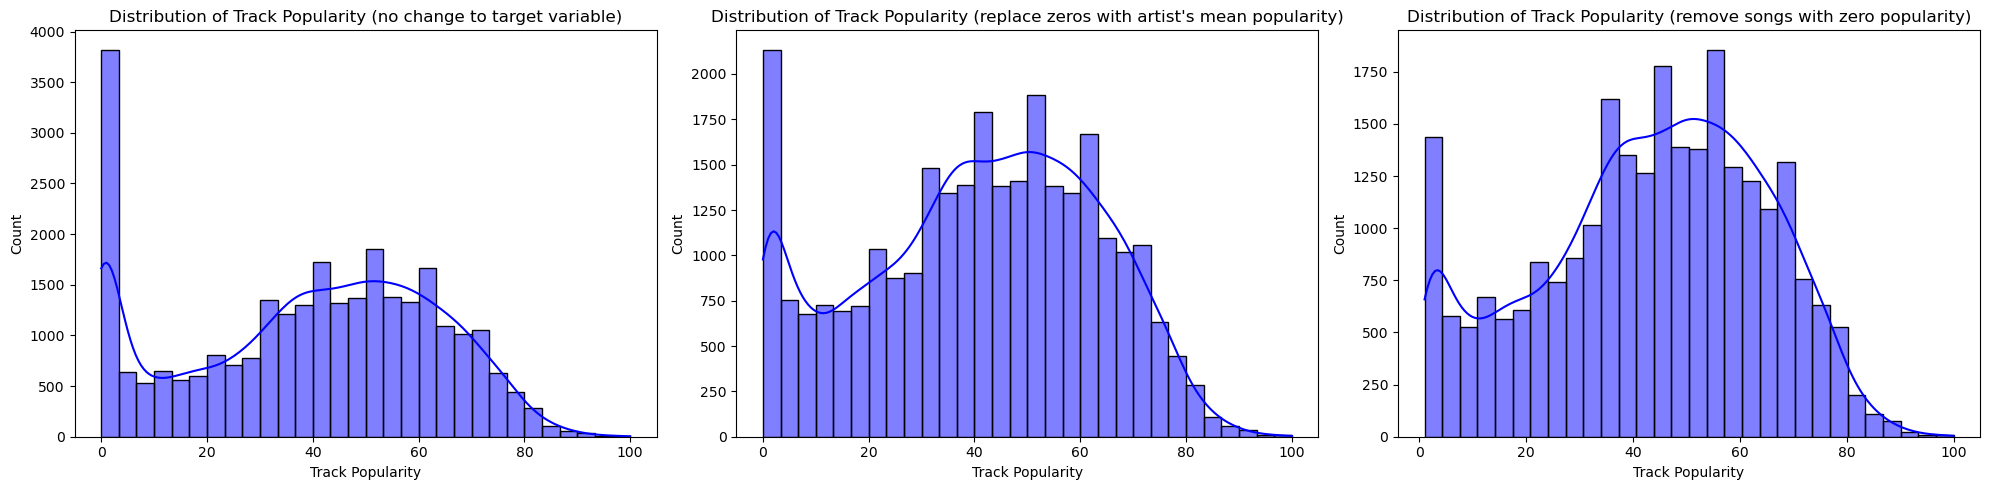

In [50]:
# plot histogram of track popularity for different ways of handling zero values
fig, axes = plt.subplots(1, 3, figsize=(20, 5)) # 3 rows 1 column

sns.histplot(df_nothing["track_popularity"], bins=30, kde=True, color='blue', ax=axes[0])
axes[0].set_title("Distribution of Track Popularity (no change to target variable)")
axes[0].set_xlabel("Track Popularity")
axes[0].set_ylabel("Count")

sns.histplot(df_0mean["track_popularity"], bins=30, kde=True, color='blue', ax=axes[1])
axes[1].set_title("Distribution of Track Popularity (replace zeros with artist's mean popularity)")
axes[1].set_xlabel("Track Popularity")
axes[1].set_ylabel("Count")

sns.histplot(df_no0["track_popularity"], bins=30, kde=True, color='blue', ax=axes[2])
axes[2].set_title("Distribution of Track Popularity (remove songs with zero popularity)")
axes[2].set_xlabel("Track Popularity")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.show()

Each of the plots above show the resulting distribution of the plots when considering three different ways to handle the large number of zero popularity tracks:
- Retain zero-popularity values as they are, with no transformation 
- Replace zero values with the artist’s mean popularity (excluding songs with zero popularity, unless all songs have zero)
- Remove all zero-popularity songs from the dataset

As we can see from the plots above, the second and third options reduce the skew. When replacing zeros with the artist's mean popularity, some zero values still remain, demonstrating that there are numerous artists where all their songs have zero popularity.

When removing all the zero popularity songs, we see that the next bin also has a lot of values representing songs with very low popularity. This again is not ideal and we might need to account for this in our analysis. When considering this option, we want to keep in mind that the ideal situation would be to have a normal distribution of the track popularity values.

We will consider all three of these options in our baseline model to understand the impact of each on the models.

#### Distribution of the numeric predictor variables

In the data pre-processing, we scaled and corrected the skewness of the quantitative variables. We can see their resulting distributions in the plots below.

Although several predictors including `instrumentalness` and `speechiness` remain imbalanced after scaling, the majority of predictors now follow a normal distribution. 

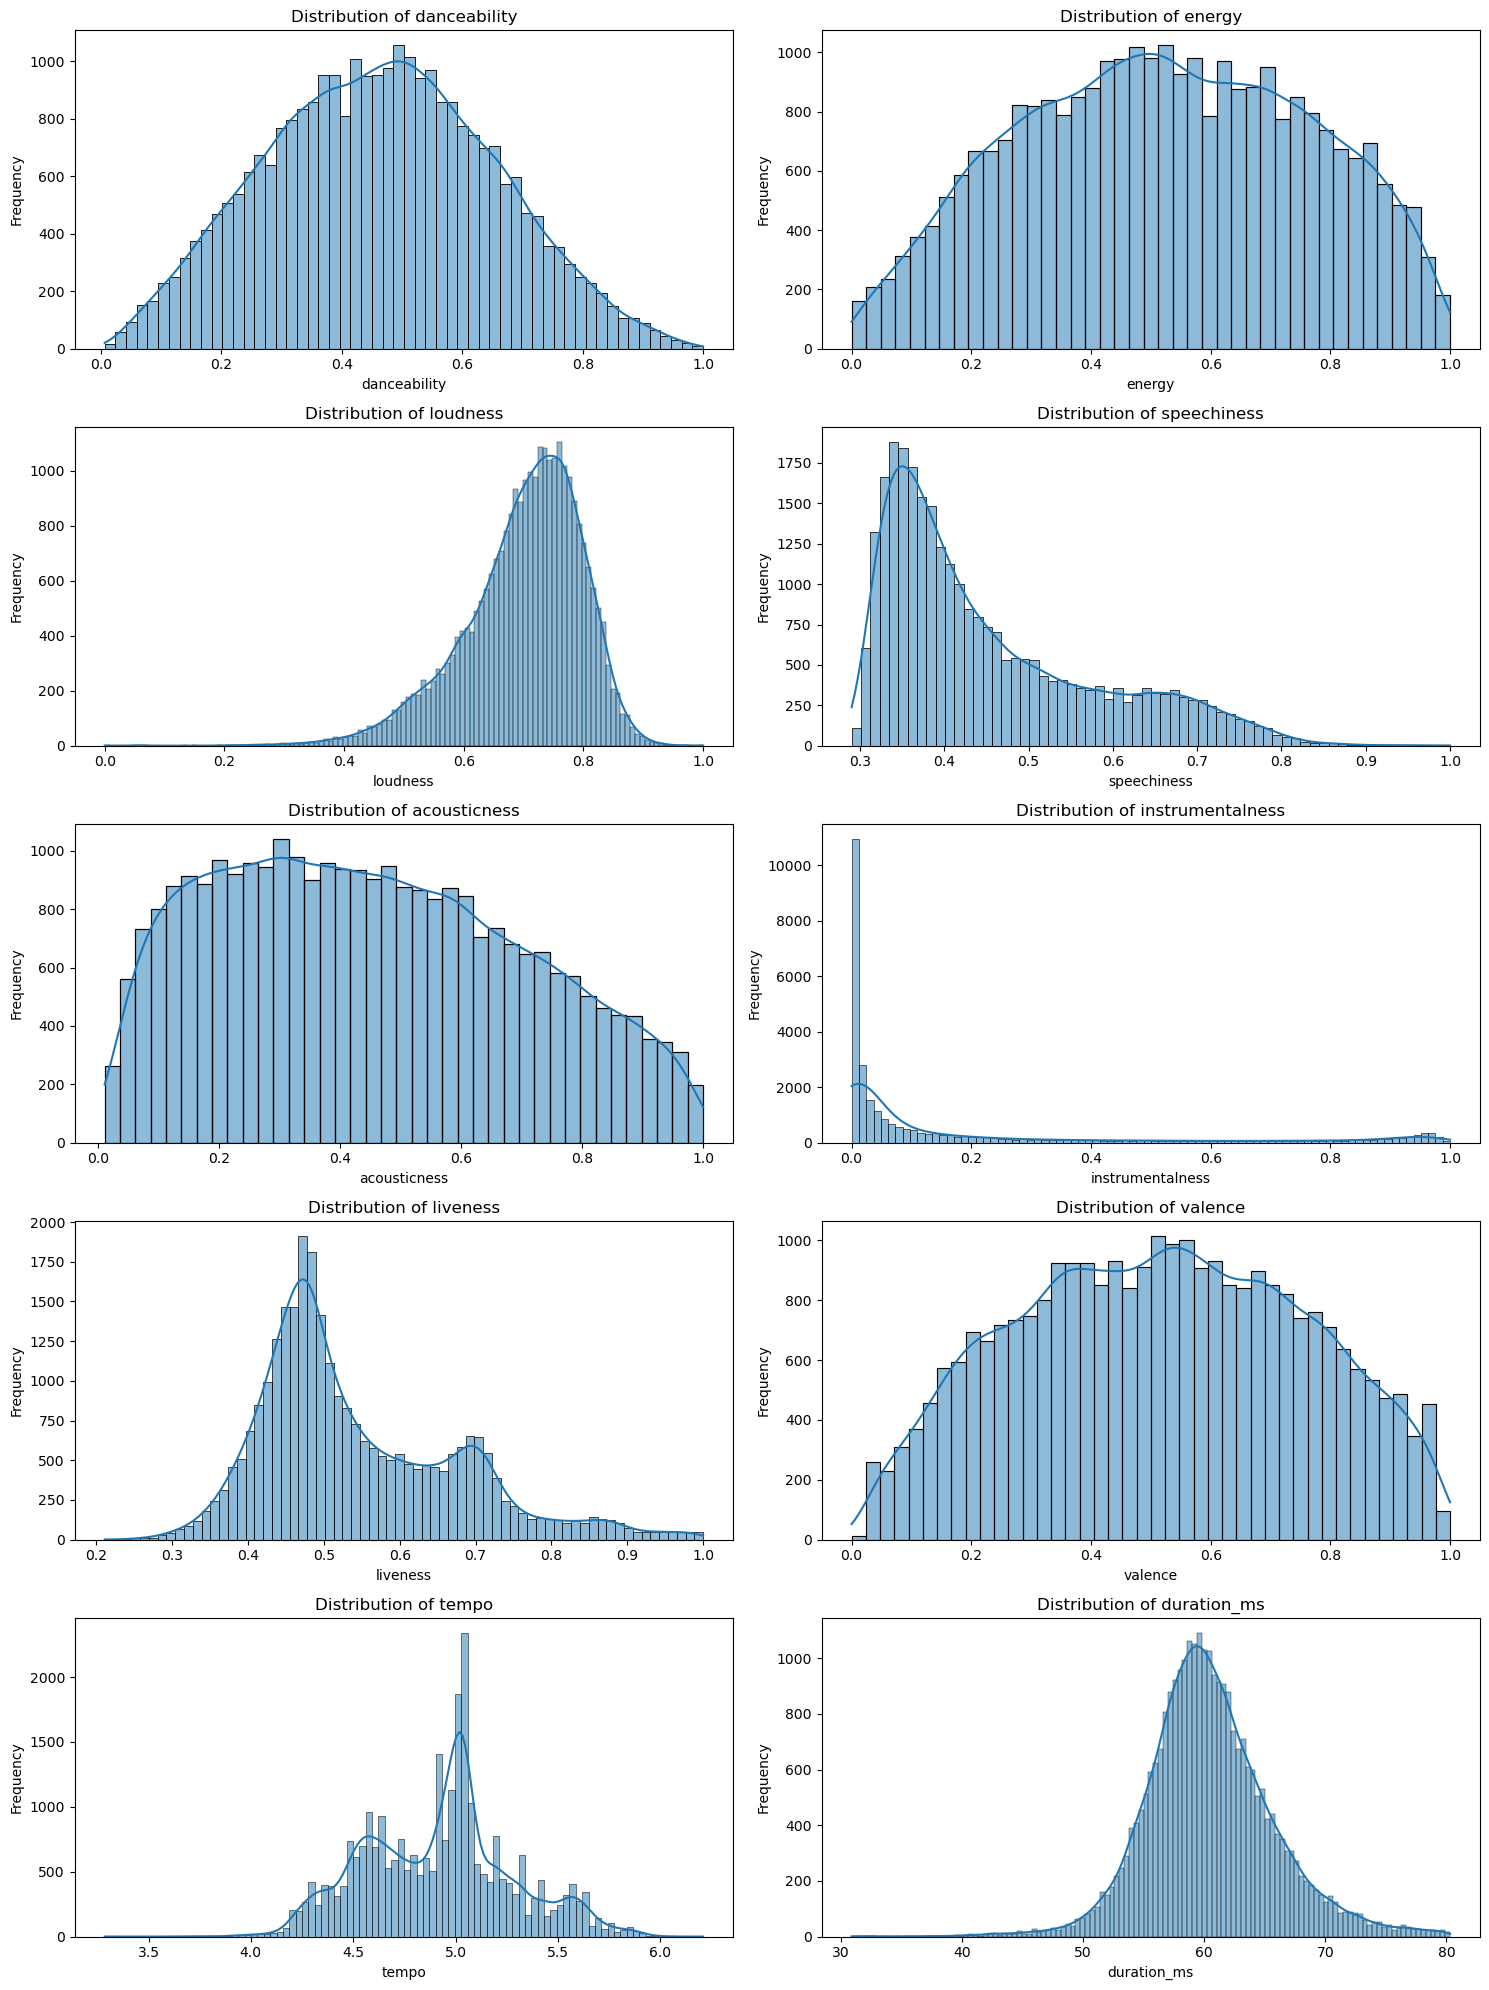

In [51]:
numeric_columns = ["danceability", "energy", "loudness", "speechiness",
    "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms"
]

plt.figure(figsize=(15, 20))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(5, 2, i)
    sns.histplot(df_nothing[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)  
    plt.ylabel("Frequency")  
plt.tight_layout()
plt.show()

#### Distribution of the categorical predictor variables

We then analyzed the categorical variables to look for any anomalies in the data. From the plot below, we can see that all genres are well-represented across the dataset and that there is no class imbalance. 

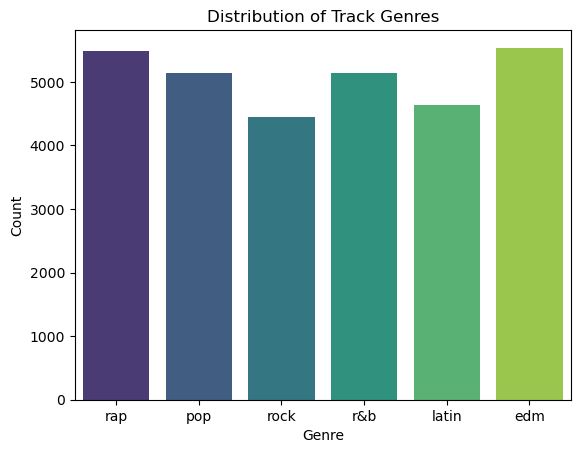

In [52]:
genre_columns = ["rap", "pop", "rock", "r&b", "latin", "edm"]
genre_data = df_nothing[genre_columns]

genre_counts = genre_data.sum().reset_index()
genre_counts.columns = ['Genre', 'Count']  

sns.barplot(data=genre_counts, x='Genre', y='Count', hue='Genre', palette="viridis", legend=False)
plt.title("Distribution of Track Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()

#### Distribution of Temporal Variables

Lastly, we investigated the distributions of the temporal variables in our dataset.

When analyzing the plots below, we found that the dataset contains many more observations of recent tracks. This could be beneficial in our case as it may mean current trends are captured more accurately and we are interested in predicting future hits. The distribution of `release month` is fairly similar across all months except for January where there is a significant spike. When combining this observation with the trends in `day of month` which show an overwhelming number of tracks released on the 1st, it might be the case that the default date imputed when the date was missing was January 1st. When carrying out our analysis, we will keep this in mind to ensure that potentially imputed values do not affect the prediction.

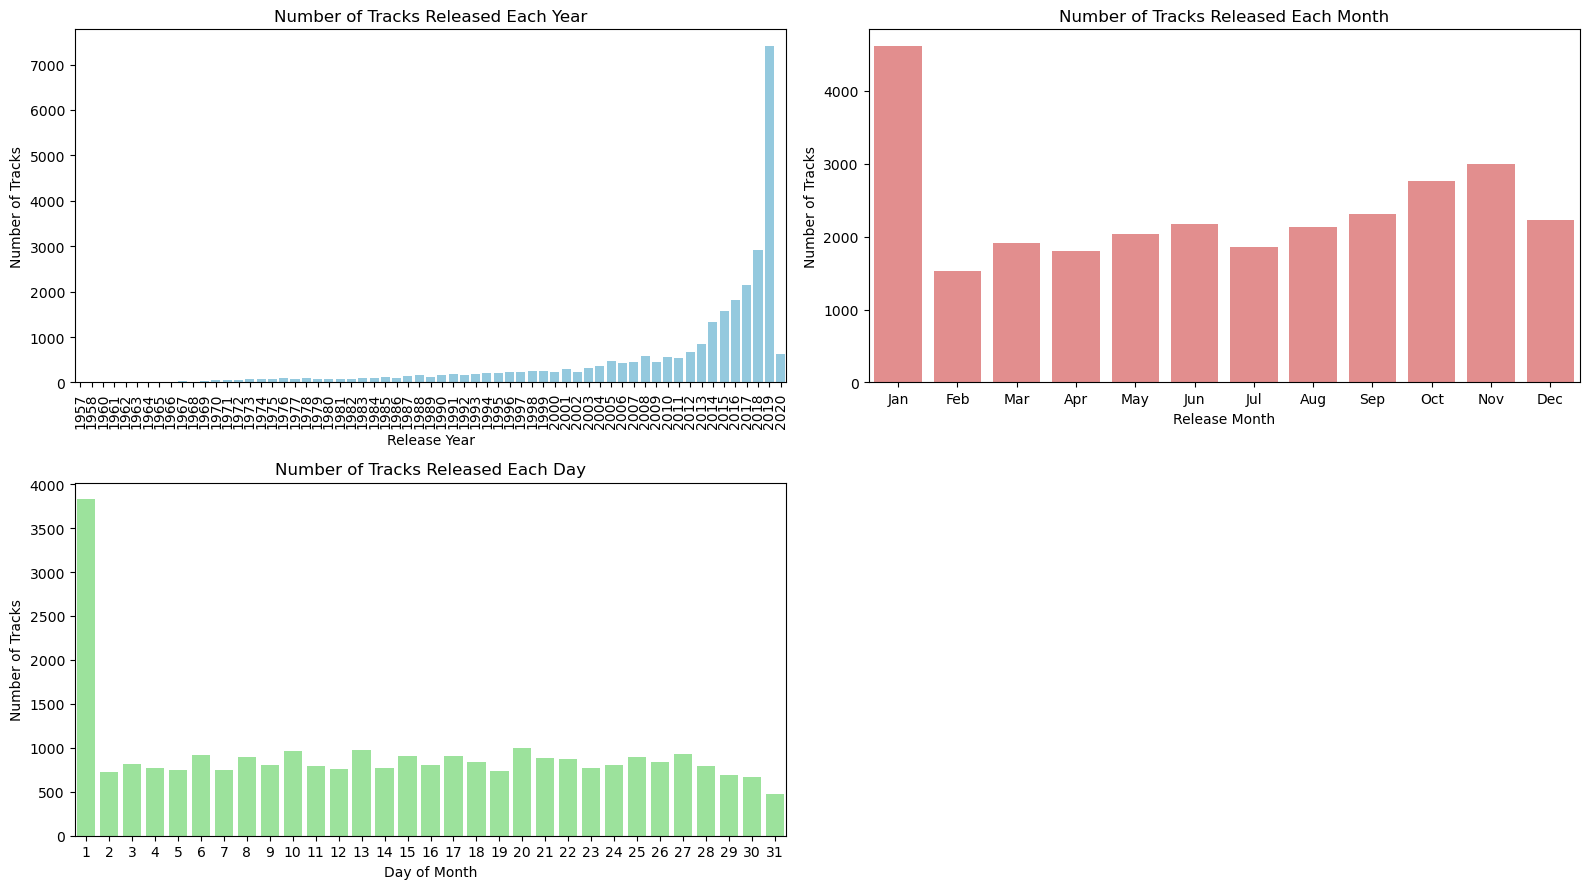

In [53]:
tracks_per_year = df_nothing['release_year'].value_counts().sort_index()
tracks_per_month = df_nothing['release_month'].value_counts().sort_index()
tracks_per_day = df_nothing['release_day'].value_counts().sort_index()

fig, axs = plt.subplots(2, 2, figsize=(16, 9))

# plotting release year distribution
sns.barplot(x=tracks_per_year.index, y=tracks_per_year.values, color="skyblue", ax=axs[0, 0])
axs[0, 0].set_title("Number of Tracks Released Each Year")
axs[0, 0].set_xlabel("Release Year")
axs[0, 0].set_ylabel("Number of Tracks")
axs[0, 0].tick_params(axis='x', rotation=90)

# release month distribution
sns.barplot(x=tracks_per_month.index, y=tracks_per_month.values, color="lightcoral", ax=axs[0, 1])
axs[0, 1].set_title("Number of Tracks Released Each Month")
axs[0, 1].set_xlabel("Release Month")
axs[0, 1].set_ylabel("Number of Tracks")
axs[0, 1].set_xticks(range(12))
axs[0, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=10)

# release day distribution
sns.barplot(x=tracks_per_day.index, y=tracks_per_day.values, color="lightgreen", ax=axs[1, 0])
axs[1, 0].set_title("Number of Tracks Released Each Day")
axs[1, 0].set_xlabel("Day of Month")
axs[1, 0].set_ylabel("Number of Tracks")

fig.delaxes(axs[1, 1])  # remove empty fourth plot

plt.tight_layout()
plt.show()

### Relationship between Track Popularity and Predictor Variables

As we can see from the plots below, there is no clear relationship between any of the quantitative nor categorical predictors and track popularity.

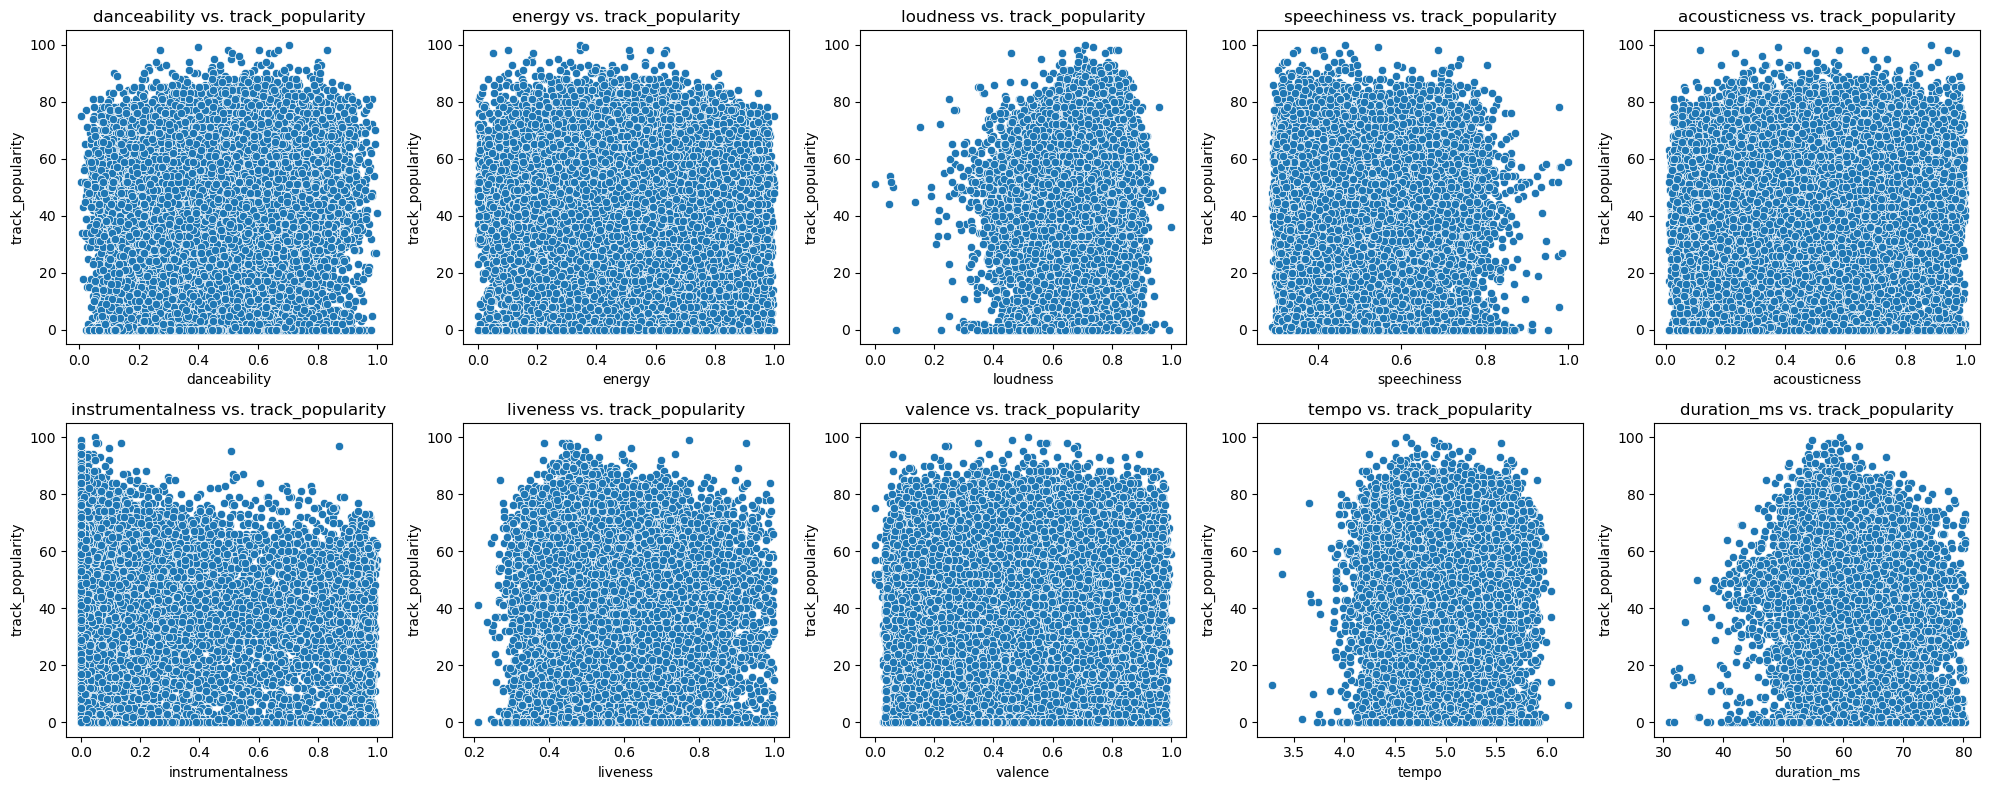

In [54]:
plt.figure(figsize=(20, 8))  
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 5, i)  # 2 rows and 5 columns
    sns.scatterplot(data=df_nothing, x=column, y="track_popularity")
    plt.title(f"{column} vs. track_popularity")
    plt.xlabel(column) 
    plt.ylabel("track_popularity") 

plt.tight_layout()
plt.show()

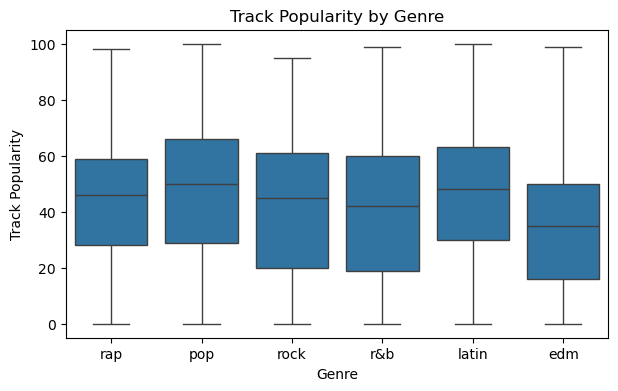

In [55]:
# make sure data is tidy; melt genre columns into a single column, binary indicator into one column
data_melted = df_nothing.melt(id_vars=["track_popularity"], value_vars=genre_columns, 
                        var_name="Genre", value_name="Is_Present")

data_genre = data_melted[data_melted["Is_Present"] == 1]

plt.figure(figsize=(7, 4))
sns.boxplot(data=data_genre, x="Genre", y="track_popularity")
plt.title("Track Popularity by Genre")
plt.xlabel("Genre")
plt.ylabel("Track Popularity")
plt.show()

Similarly, when analyzing the relationship between the temporal variables and the target variable we find no clear relationship. This was slightly
surprising as we might expect specific days such as Christmas or ‘summer songs’ months to influence a song’s popularity. 

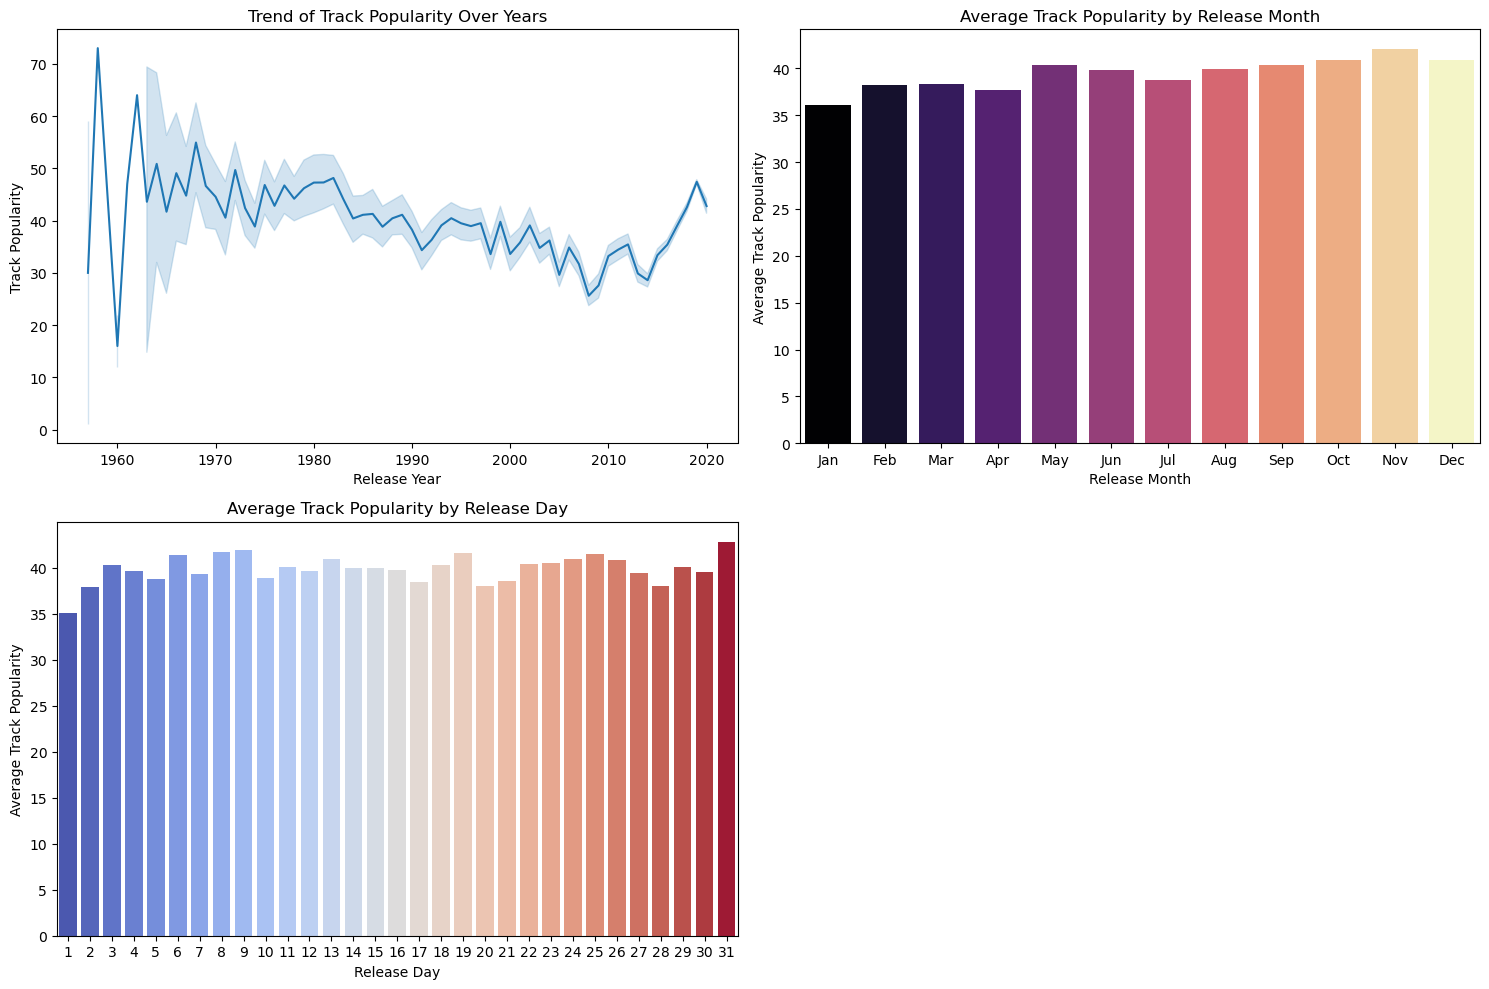

In [56]:
popularity_by_month = df_nothing.groupby('release_month')['track_popularity'].mean().reset_index()
popularity_by_day = df_nothing.groupby('release_day')['track_popularity'].mean().reset_index()

fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Adjust figsize for better readability

# trend of track popularity over years
sns.lineplot(data=df_nothing, x="release_year", y="track_popularity", errorbar=('ci', 95), ax=axs[0, 0])
axs[0, 0].set_title("Trend of Track Popularity Over Years")
axs[0, 0].set_xlabel("Release Year")
axs[0, 0].set_ylabel("Track Popularity")

# track popularity by release month
sns.barplot(data=popularity_by_month, x="release_month", y="track_popularity", hue="release_month", palette="magma", ax=axs[0, 1], dodge=False, legend=False)
axs[0, 1].set_title("Average Track Popularity by Release Month")
axs[0, 1].set_xlabel("Release Month")
axs[0, 1].set_ylabel("Average Track Popularity")
axs[0, 1].set_xticks(range(12))
axs[0, 1].set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

# track popularity by release day
sns.barplot(data=popularity_by_day, x="release_day", y="track_popularity", hue="release_day", palette="coolwarm", ax=axs[1, 0], dodge=False, legend=False)
axs[1, 0].set_title("Average Track Popularity by Release Day")
axs[1, 0].set_xlabel("Release Day")
axs[1, 0].set_ylabel("Average Track Popularity")
axs[1, 0].set_xticks(range(0, 31))
axs[1, 0].set_xticklabels(range(1, 32))

fig.delaxes(axs[1, 1]) # remove empty subplot 

plt.tight_layout()
plt.show()

### Feature correlation

We investigate potential correlation between the numerical predictor variables. As we can see, loudness and energy appear to be fairly correlated, although there are no extremely strong correlations to take note of.

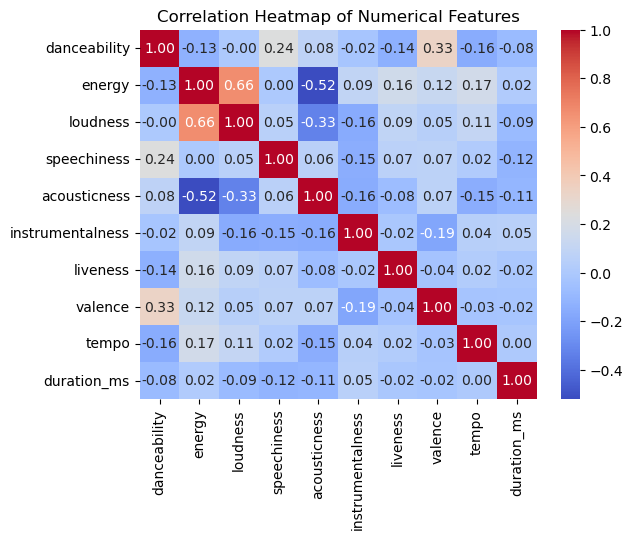

In [57]:
sns.heatmap(df_nothing[numeric_columns].corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

### Outliers

As we noted from analysis in our prior milestone, this dataset contains a large number of outliers, leverage and influential points. After our initial analysis, we removed outliers that appeared to be particularly egregious and potentially mistakes. None of the remaining outliers appeared to be isolated, and they were distributed across all music genres.

From our knowledge about music more generally, it is not surprising that there are outliers. Music inherently has a lot of variation, particularly as artists tend to experiment occasionally with unusual styles or characteristics. We therefore decide to keep these remaining outliers, as they represent distinct styles of music. For our case of prediction, keeping outliers might make the model more adaptable to different music styles. The distribution of the variables with the remaining outliers can be seen below.

In [58]:
numeric_df = df_nothing.select_dtypes(include=[np.number])
outlier_counts = (np.abs(zscore(numeric_df)) > 3).sum().astype(int)
print("Outliers per predictor:")
print(outlier_counts)

Outliers per predictor:
track_popularity          0
danceability              0
energy                    0
key                       0
loudness                238
mode                      0
speechiness              93
acousticness              0
instrumentalness          0
liveness                260
valence                   0
tempo                    17
duration_ms             368
edm                       0
r&b                       0
rap                       0
latin                     0
rock                      0
pop                       0
artist_track_encoded      1
release_year            748
release_month             0
release_day               0
Cluster                   0
dtype: int64


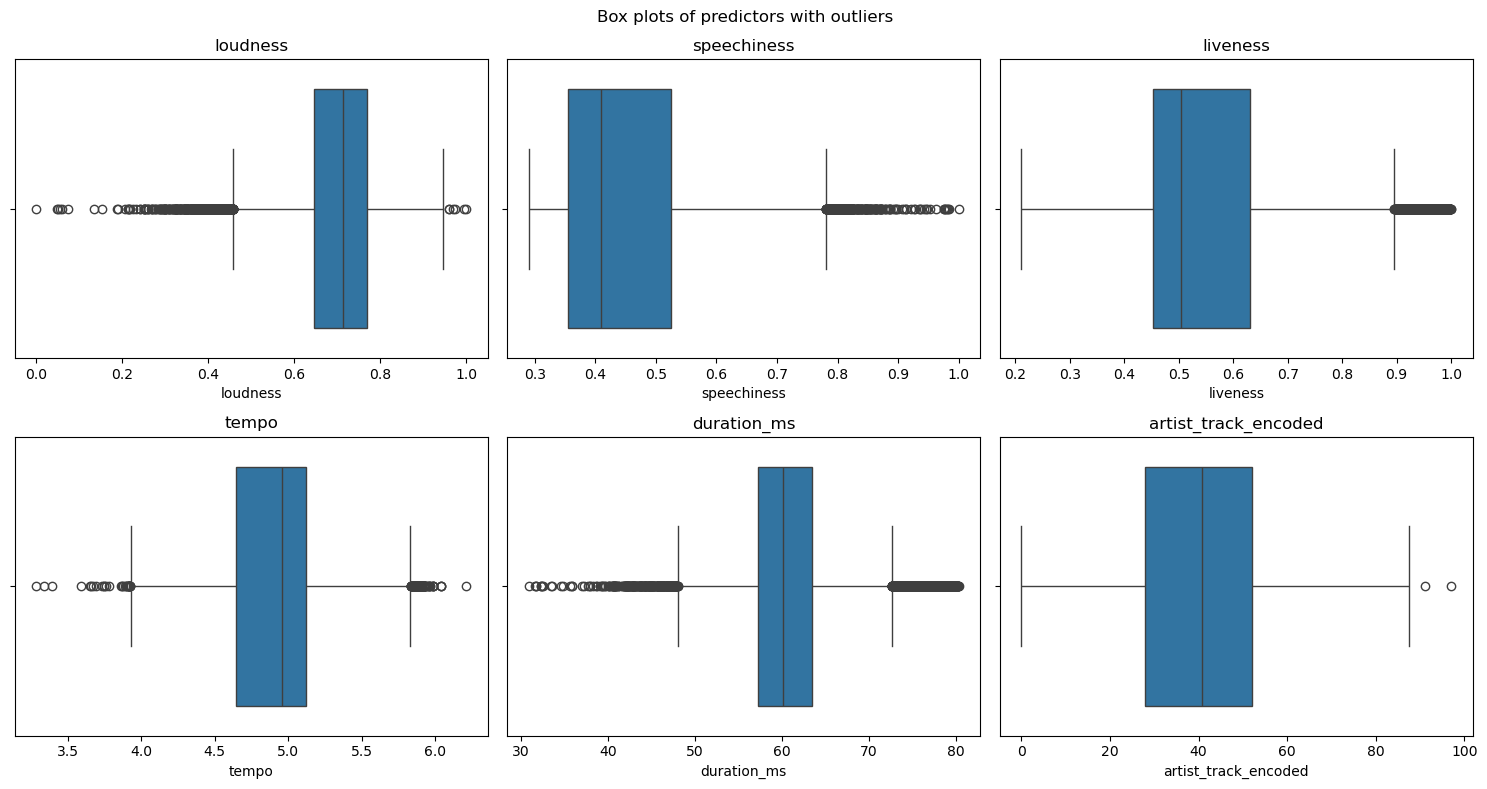

In [59]:
outlier_predictors = ["loudness", "speechiness", "liveness", "tempo", "duration_ms", "artist_track_encoded"]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle("Box plots of predictors with outliers")

for i, predictor in enumerate(outlier_predictors):
    row, col = divmod(i, 3)
    sns.boxplot(x=df_nothing[predictor], ax=axes[row, col])
    axes[row, col].set_title(f"{predictor}")

plt.tight_layout()
plt.show()

## 3. Baseline Models
<a id="baseline"></a>

As discussed above, we considered three different ways to deal with the skew in the target variable where there are a high number of points with zero popularity. We will test our baseline models against these 3 preprocessing methods to evaluate which is the best.

We will consider three different baseline models before choosing the best:
- Linear regression (predicting the popularity value)
- Logistic regression (classification into different 'popularity levels')
- Decision tree (classification into different 'popularity levels')

There are two aprproaches we could take for determining the popularity of a song. As `track_popularity` is a numerical value, we could look at the raw numerical value that is predicted. Alternatively, we could divide different popularities into bins indicating the level of popularity (where songs at level 0 are least popular, and those at level 4 are the most popular). Linear regression addresses this first approach, where as logistic regression and decision trees will address the latter. 

# todo: change analysis results with new MSE / accuracy values

In [60]:
# Split each of the 3 datasets into train and test sets
X_nothing = df_nothing.drop(columns=["track_popularity"])
y_nothing = df_nothing["track_popularity"]

X_train_nothing, X_test_nothing, y_train_nothing, y_test_nothing = train_test_split(X_nothing, y_nothing, test_size=0.2, random_state=42)

X_0mean = df_0mean.drop(columns=["track_popularity"])
y_0mean = df_0mean["track_popularity"]

X_train_0mean, X_test_0mean, y_train_0mean, y_test_0mean = train_test_split(X_0mean, y_0mean, test_size=0.2, random_state=42)

X_no0 = df_no0.drop(columns=["track_popularity"])
y_no0 = df_no0["track_popularity"]

X_train_no0, X_test_no0, y_train_no0, y_test_no0 = train_test_split(X_no0, y_no0, test_size=0.2, random_state=42)

In [61]:
# define helper function to compare baseline models efficiently

def get_metrics(model, name: str, data: tuple) -> dict:
    x_train, x_test, y_train, y_test = data
    d = {}
    y_hat_train = model.predict(x_train)
    y_hat_test = model.predict(x_test)
    d['name'] = name
    d['train_mse'] = mean_squared_error(y_train, y_hat_train)
    d['test_mse'] = mean_squared_error(y_test, y_hat_test)
    d['r2_train'] = r2_score(y_train, y_hat_train)
    d['r2_test'] = r2_score(y_test, y_hat_test)
    return d

### Regression Baseline Model
<a id="sub1"></a>

As discussed above, we will utilize linear regression to predict a raw value for `track_popularity`, considering each of the three options for dealing with the large number of zero popularity tracks.

**Linear regression - no transformation to zero popularity tracks**

In [62]:
lin_reg_nothing = LinearRegression().fit(X_train_nothing, y_train_nothing)
data = (X_train_nothing, X_test_nothing, y_train_nothing, y_test_nothing)
results = [get_metrics(lin_reg_nothing, 'Linear Regression - no transformation', data)]

**Linear regression - impute with mean of artist's non-zero popularity songs**

In [63]:
lin_reg_0mean = LinearRegression().fit(X_train_0mean, y_train_0mean)
data = (X_train_0mean, X_test_0mean, y_train_0mean, y_test_0mean)
results.append(get_metrics(lin_reg_0mean, 'Linear Regression - imputed popularity', data))

**Linear regression - remove songs with zero popularity**

In [64]:
lin_reg_no0 = LinearRegression().fit(X_train_no0, y_train_no0)
data = (X_train_no0, X_test_no0, y_train_no0, y_test_no0)
results.append(get_metrics(lin_reg_no0, 'Linear Regression - zero popularity removed', data))

**Linear regression baseline model results**

In [65]:
pd.DataFrame(results)

,name,train_mse,test_mse,r2_train,r2_test
0,Linear Regression - no transformation,245.039662,246.167447,0.562991,0.564431
1,Linear Regression - imputed popularity,198.073948,193.928842,0.595469,0.601986
2,Linear Regression - zero popularity removed,216.015713,216.208288,0.514456,0.517065


As we can see from the results, Model 0 (no transformation) has both the lowest train and test MSE, indicating that it is better at predicting `track_popularity` than the other two models. Furthermore, the similar train and testing MSEs suggest that the model is not overfit. The performance of Model 2 is fairly comparable when looking at MSE, but the performance of Model 1 with imputed popularities is far worse. The test MSE of Model 1 of 45.7 is far higher than those observed for the other models - it seems that imputing the popularity using artist mean may have introduced noise or inaccurate representations of the data, making the predictions worse.

Model 0 had the highest R-squared score across both test and training sets, although the score for Model 2 was similar. The R-squared test score for Model 0 indicates that the model captures 97.9% of the variance in the data. While the R-squared score for Model 1 suggests it still explains the majority of variance in the data (around 90%), this is notably lower than the other two models. This may be due to the nature of the imputation which could have introduced inaccuracies and bias.

For linear regression, both methods that address the zero-popularity tracks do not appear to improve the model.

### Classification Baseline Models (using 3 levels)
<a id="sub2"></a>

For the classification methods, we will break up `track_popularity` into 3 levels of popularity where 0 represents the least popular songs and 2 are the most popular songs.

##### Encode `track_popularity` into levels

In [66]:
# create a levels and labels for the popularity
num_categories = 3

bins = [i * (100 / num_categories) for i in range(num_categories + 1)]
labels = list(range(0, num_categories))

In [67]:
# create a new column for the popularity category level
df_nothing['popularity_category'] = pd.cut(
    df_nothing['track_popularity'], bins=bins, labels=labels, include_lowest=True)

df_nothing = df_nothing.drop(columns=["track_popularity"])

df_0mean['popularity_category'] = pd.cut(
    df_0mean['track_popularity'], bins=bins, labels=labels, include_lowest=True)

df_0mean = df_0mean.drop(columns=["track_popularity"])

df_no0['popularity_category'] = pd.cut(
    df_no0['track_popularity'], bins=bins, labels=labels, include_lowest=True)

df_no0 = df_no0.drop(columns=["track_popularity"])

**Split into train and test sets with the new levels**

In [68]:
X_nothing = df_nothing.drop(columns=["popularity_category"])
y_nothing = df_nothing["popularity_category"]

X_train_nothing, X_test_nothing, y_train_nothing, y_test_nothing = train_test_split(X_nothing, y_nothing, test_size=0.2, random_state=42)

X_0mean = df_0mean.drop(columns=["popularity_category"])
y_0mean = df_0mean["popularity_category"]

X_train_0mean, X_test_0mean, y_train_0mean, y_test_0mean = train_test_split(X_0mean, y_0mean, test_size=0.2, random_state=42)

X_no0 = df_no0.drop(columns=["popularity_category"])
y_no0 = df_no0["popularity_category"]

X_train_no0, X_test_no0, y_train_no0, y_test_no0 = train_test_split(X_no0, y_no0, test_size=0.2, random_state=42)

We can visualize the spread of the data now that it has been split into different levels of popularity - we call these the popularity category where 0 are the least popular songs and 2 are the most popular songs.

From the plots below, we can see that category 2 has the lowest number of songs across the board. This supports our understanding of the nature of music data: not many songs become hits. We can see from these distributions that the number of values in the lowest popularity category decreased when transforming zero popularity values. When considering this classification approach, it seems that the zero values for popularity may not be as impactful as when using linear regression - zero values are no longer as much of a problem.

However, we note that there is now imbalance with cateogry 2 having far fewer values than the other categories which we will need to account for.

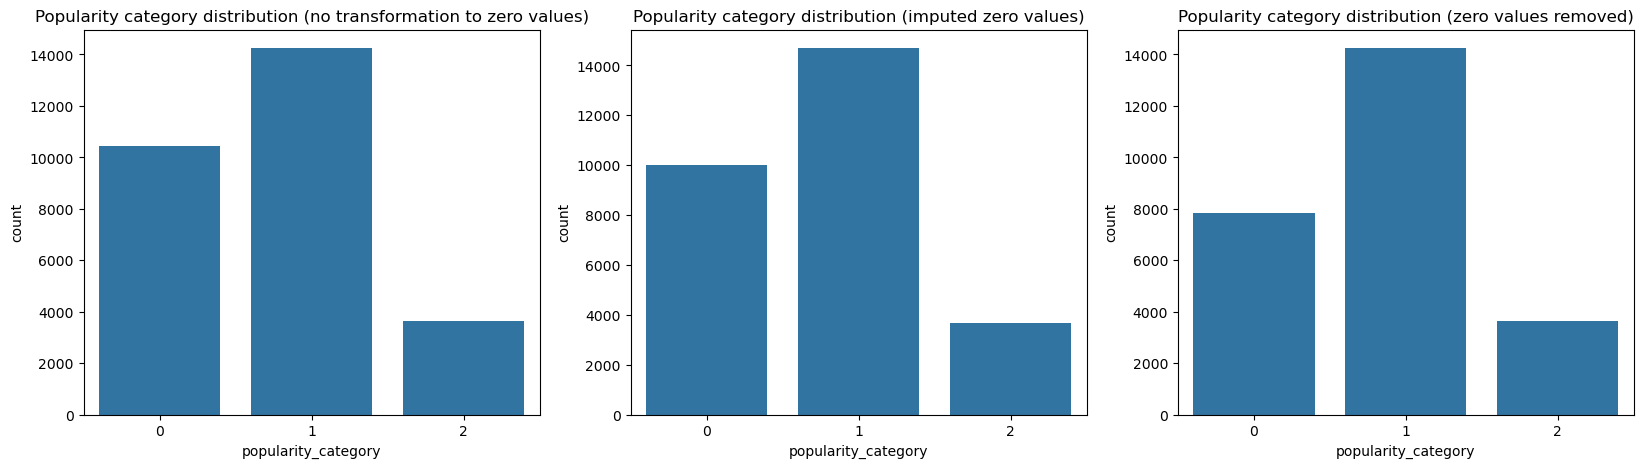

In [69]:
# plot distribution of popularity categories

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.countplot(x='popularity_category', data=df_nothing, ax=ax[0])
ax[0].set_title('Popularity category distribution (no transformation to zero values)')

sns.countplot(x='popularity_category', data=df_0mean, ax=ax[1])
ax[1].set_title('Popularity category distribution (imputed zero values)')

sns.countplot(x='popularity_category', data=df_no0, ax=ax[2])
ax[2].set_title('Popularity category distribution (zero values removed)')

plt.show()

### Decision Tree
<a id="subclass1"></a>

We will consider various depths for each of the decision trees.

In [70]:
results = []
depths = np.arange(1, 21) # list of depths to try for the Decision Tree

**Decision tree - no transformation to zero popularity tracks**

In [71]:
train_accuracy_nothing = []
test_accuracy_nothing = []
for depth in depths:
    clf_nothing = DecisionTreeClassifier(max_depth=depth)
    clf_nothing.fit(X_train_nothing, y_train_nothing)
    
    train_accuracy_nothing.append(accuracy_score(y_train_nothing, clf_nothing.predict(X_train_nothing)))
    test_accuracy_nothing.append(accuracy_score(y_test_nothing, clf_nothing.predict(X_test_nothing)))

**Decision tree - impute with mean of artist's non-zero popularity songs**

In [72]:
train_accuracy_0mean = []
test_accuracy_0mean = []
for depth in depths:
    clf_0mean = DecisionTreeClassifier(max_depth=depth)
    clf_0mean.fit(X_train_0mean, y_train_0mean)
    
    train_accuracy_0mean.append(accuracy_score(y_train_0mean, clf_0mean.predict(X_train_0mean)))
    test_accuracy_0mean.append(accuracy_score(y_test_0mean, clf_0mean.predict(X_test_0mean)))

**Decision Tree - remove songs with zero popularity**

In [73]:
train_accuracy_no0 = []
test_accuracy_no0 = []
for depth in depths:
    clf_no0 = DecisionTreeClassifier(max_depth=depth)
    clf_no0.fit(X_train_no0, y_train_no0)
    
    train_accuracy_no0.append(accuracy_score(y_train_no0, clf_no0.predict(X_train_no0)))
    test_accuracy_no0.append(accuracy_score(y_test_no0, clf_no0.predict(X_test_no0)))

**Decision tree baseline model results**

In [74]:
# finding the best depth for each tree to report results
best_result_nothing = max(test_accuracy_nothing)
best_depth_nothing = depths[test_accuracy_nothing.index(best_result_nothing)]

results.append(["Decision Tree", "No transformation", best_result_nothing, best_depth_nothing])

best_result_0mean = max(test_accuracy_0mean)
best_depth_0mean = depths[test_accuracy_0mean.index(best_result_0mean)]

results.append(["Decision Tree", "Imputed values", best_result_0mean, best_depth_0mean])

best_result_no0 = max(test_accuracy_no0)
best_depth_no0 = depths[test_accuracy_no0.index(best_result_no0)]

results.append(["Decision Tree", "Zeros removed", best_result_no0, best_depth_no0])

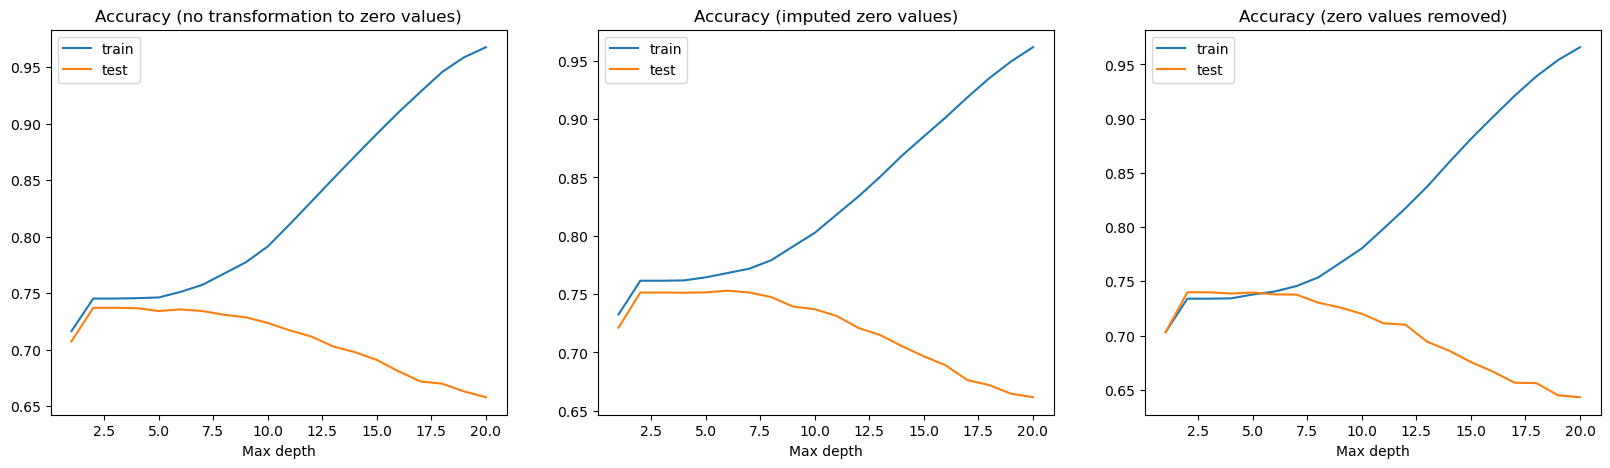

In [75]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(depths, train_accuracy_nothing, label='train')
ax[0].plot(depths, test_accuracy_nothing, label='test')
ax[0].set_title('Accuracy (no transformation to zero values)')
ax[0].set_xlabel('Max depth')
ax[0].legend()

ax[1].plot(depths, train_accuracy_0mean, label='train')
ax[1].plot(depths, test_accuracy_0mean, label='test')
ax[1].set_title('Accuracy (imputed zero values)')
ax[1].set_xlabel('Max depth')
ax[1].legend()

ax[2].plot(depths, train_accuracy_no0, label='train')
ax[2].plot(depths, test_accuracy_no0, label='test')
ax[2].set_title('Accuracy (zero values removed)')
ax[2].set_xlabel('Max depth')
ax[2].legend()

plt.show()

In [76]:
col = ["Model", "Dataset", "Test Accuracy", "Best Depth"]

pd.DataFrame(results, columns=col)

,Model,Dataset,Test Accuracy,Best Depth
0,Decision Tree,No transformation,0.737083,2
1,Decision Tree,Imputed values,0.752954,6
2,Decision Tree,Zeros removed,0.739899,2


From the results above, we can see that decision trees performed similarly across all three ways of dealing with the zero values. Furthermore, the best depth for each, assessed using the accuracy metric, all preferred shallower trees. As we can see from the plots above, when increasing the depth past around 5, the trees became overfit across all three trees as the test accuracy would begin to decrease.

The decision tree with no transformation performed the best, although this performance was only slightly better than the other two. Unlike with the linear regression model, there was not a large different between the performance outcome metric across the three models. It is notable that the decision tree with no transformation to the data performed best, similarly to the outcome with the linear regression models.

### Logistic Regression
<a id="subclass2"></a>

**Logistic regression - no transformation to zero popularity tracks**

In [77]:
log_reg_nothing = LogisticRegression(solver='saga', max_iter = 2000).fit(X_train_nothing, y_train_nothing)
accuracy_score_train = log_reg_nothing.score(X_train_nothing, y_train_nothing)
accuracy_score_test = log_reg_nothing.score(X_test_nothing, y_test_nothing)
results.append(['Logistic Regression', "No transformation", accuracy_score_test])

print(f"train accuracy: {accuracy_score_train} \n test accuracy: {accuracy_score_test}")

train accuracy: 0.7375220458553792 
 test accuracy: 0.7300299770763534


/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Logistic regression - impute with mean of artist's non-zero popularity songs**

In [78]:
log_reg_0mean = LogisticRegression(solver='saga', max_iter = 2000).fit(X_train_0mean, y_train_0mean)
accuracy_score_train = log_reg_0mean.score(X_train_0mean, y_train_0mean)
accuracy_score_test = log_reg_0mean.score(X_test_0mean, y_test_0mean)
results.append(['Logistic Regression' ,'Imputed values', accuracy_score_test])

print(f"train accuracy: {accuracy_score_train} \n test accuracy: {accuracy_score_test}")

train accuracy: 0.7509809973105243 
 test accuracy: 0.7416681361311938


/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Logistic regression - remove songs with zero popularity**

In [79]:
log_reg_no0 = LogisticRegression(solver='saga', max_iter = 2000).fit(X_train_no0, y_train_no0)
accuracy_score_train = log_reg_no0.score(X_train_no0, y_train_no0)
accuracy_score_test = log_reg_no0.score(X_test_no0, y_test_no0)
results.append(['Logistic Regression','Zeros removed', accuracy_score_test])

print(f"train accuracy: {accuracy_score_train} \n test accuracy: {accuracy_score_test}")

train accuracy: 0.7207596658247523 
 test accuracy: 0.7245532245532246


/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Logistic regression baseline model results**

In [80]:
pd.DataFrame(results, columns=col)

,Model,Dataset,Test Accuracy,Best Depth
0,Decision Tree,No transformation,0.737083,2.0
1,Decision Tree,Imputed values,0.752954,6.0
2,Decision Tree,Zeros removed,0.739899,2.0
3,Logistic Regression,No transformation,0.730030,NaN
4,Logistic Regression,Imputed values,0.741668,NaN
5,Logistic Regression,Zeros removed,0.724553,NaN


From the results above, we can see that the logistic regression model which utilised the imputed data performed best across train and test accuracies. This coincides with what we have seen for the linear regression and decision tree models.

**Selecting our baseline model**

Across the linear regression, decision tree and logistic regression models, the dataset with imputed values for zeros performed the best. Moving forward, we therefore decide **to use the dataset with imputed values**.

We decide on using a **classification** approach as opposed to regression as it may be more interpretable in this context. For example, distinguishing between 3 levels of popularity is more understandable than a sliding scale of popularity values such as in the case of reporting these predictions and explaining the system to industry personnel. Furthermore, the classification approach is more robust to the number of zero popularity values - when grouped together in the lowest bin, the data is not as imbalanced anymore. 

We note that the accuracies for the logistic regression models are lower than those for the decision trees across the board. This could be due to the complexity of the dataset or perhaps the imbalance in the dataset meaning that decision trees may simply be more suited to our dataset, and that a more complex decision boundary captures the data better. We therefore decide to use the Decision Tree as our baseline model, and will refine it further in our next milestone.

Therefore, we select the Decision Tree and the dataset with no transformation to the zero values for our baseline model.

## Final model pipeline
<a id="pipeline"></a>

Based on our analysis, we will move forward with the Decision Tree classifier as our baseline model using the dataset with no transformation to the zero popularity values. We will explore different options to try to further improve our classifier such as Random Forests and Boosting, as well as fine tuning the hyperparameters. 

As discussed, we will use the dataset with no transformation to the zero values. Given the way we divided the popularity into levels, the zero values are no longer as problematic as before, however we do now have an imbalance as there are relatively few songs that are hits. We will therefore consider data resampling techniques such as SMOTE in our model pipeline.

#### Feature Engineering

We start by defining a FeatureEngineering class for our pipeline. Efficiently transforming our dataset will allow us to try different transformations to understand which transformations might work best.

In [81]:
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # no fitting required but the method is necessary
        return self

    def transform(self, X):
        X = X.copy()

       # some feature engineering
        X['energy_danceability'] = X['energy'] * X['danceability']
        X['tempo_energy_interaction'] = X['tempo'] * X['energy']
        X['dance_valence'] = X['danceability'] * X['valence']

        X['track_age'] = 2024 - X['release_year']
        
        # flexibility to add more features in the future
        X['release_season'] = X['release_month'].apply(self._categorize_season)
        X['loudness_log'] = np.log1p(X['loudness'].clip(lower=1))
        X['instrumentalness_log'] = np.log1p(X['instrumentalness'])

        X = pd.get_dummies(X, columns=['release_season'], drop_first=True)

        return X
    
    @staticmethod
    def _categorize_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'

#### Pipeline definition

**!! Important !!**

As the pre-processing was done in an other notebook and saved into a new CSV files, we do not need to include a pre-processing step in our pipeline.

**Re-sampling**

As discussed above, category 4 (the most popular songs) has disproportionately few samples compared to the other categories. One possible way to handle this is to use re-sampling. We can directly incorporate imputation in our pipeline.

Here we use SMOTE for our baseline, however, we may consider other options as we fine-tune our model to see which technique works best. 

In [82]:
resampler = SMOTE(random_state=42)
model= DecisionTreeClassifier(class_weight='balanced', random_state=42) 

pipeline_decision_tree = Pipeline([
    ('feature_engineering', FeatureEngineeringTransformer()),
    ('resampler', resampler),
    ('model', model)
])

pipeline_decision_tree

Pipeline(steps=[('feature_engineering', FeatureEngineeringTransformer()),
                ('resampler', SMOTE(random_state=42)),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

We will employ this pipeline as we fine-tune our parameters, as well as test out techniques such as random forest and gradient boosting. 

#### Example of the pipeline

In [83]:
pipeline_decision_tree.fit(X_train_0mean, y_train_0mean)

accuracy_score_train = pipeline_decision_tree.score(X_train_0mean, y_train_0mean)
accuracy_score_test = pipeline_decision_tree.score(X_test_0mean, y_test_0mean)

print(f"Train accuracy: {accuracy_score_train:.2f}")
print(f"Test accuracy: {accuracy_score_test:.2f}")


Train accuracy: 1.00
Test accuracy: 0.63


## Classification model

In our baseline model stage, we determined that the best dataset to use in this case is that where the zeros are not transformed. Since we decided on a decision tree as our baseline model, we are now working with popularity categories as our outcome variable - this change means that the skew from the large number of zero-popularity tracks is now no longer an issue. However, we now have a new issue in that the popularity categories are imbalanced due to the nature of music data - not that many songs become hits and therefore fewer songs fall into the most popular category.

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X_0mean, y_0mean, test_size=0.2, random_state=42)

We will also perform cross-validation during the model training for fine-tuning hyperparmeters. In this case, we decide to use Stratified K-Fold cross-validation. We decide to use this here because, as discussed above, there is an imbalanced distribution across the different categories of the outcome variable track popularity. This way, we ensure that the dataset's distribution is reflected across all folds and guarantee representation of the minority classes in each fold. 

In [85]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [86]:
results = []

#### Evaluating the models - using the F1 score

Given the imbalance in our dataset, we choose to compare the models using the F1 score to avoid misrepresenting model performance on the minority class. Furthermore, in the context of this problem, we also care about false positives and false negatives as there are costs involved with incorrectly identifying songs, or not being able to capitalize on potential hits. That said, we note that we may be more concerned about false positives than false negatives - false negatives would be songs that are not initially identified as being popular, but may turn out to be hits. In these cases, labels can begin to capitalize on a song's popularity after the fact (although this would not be ideal). However, for false negatives, a lot of resources could go into a song that is predicted to become popular, when in fact it does not resonate with audiences as anticipated.

#### SMOTE

Given the imbalance in our dataset, we include SMOTE as part of our pipeline across all models. The most popular songs (category 2) are underrepresented in the dataset, however they are the most important as identifying hit songs is the most important component of our predictions. The most popular songs are the ones that both consumers and the industry will want to prioritize.

### Fine-tuning the Decision Tree

We begin finetuning the Decision Tree baseline model to improve its accuracy. We firstly use GridSearchCV to find the best hyperparameters for the models.

In [87]:
start_time = time.time()

param_grid = {
    'model__max_depth': [None, 5, 7, 10,],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': [None, 'sqrt', 'log2'],
    'model__criterion': ['gini', 'entropy']
}

model = DecisionTreeClassifier(class_weight='balanced', random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline_decision_tree,
    param_grid=param_grid,
    scoring='f1_macro',  
    cv=cv,                
    n_jobs=-1,           
    verbose=1
)
# fit the model
grid_search.fit(X_train, y_train)

end_time = time.time()
training_duration = end_time - start_time
print(f"Total training time: {training_duration:.2f} seconds")

# extract best hyperparameters and best score from gridsearch
print("Optimal hyperparameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_pipeline = grid_search.best_estimator_
# predict using best hyperparameters
y_pred = best_pipeline.predict(X_test)

print("Classification Report using optimal hyperparmeters:")
print(classification_report(y_test, y_pred))

accuracy_decision_tree = accuracy_score(y_test, y_pred)
print("Test score (using optimal hyperparameters):", accuracy_decision_tree)
f1_decision_tree = f1_score(y_test, y_pred, average='macro')
print("F1 score:", f1_decision_tree)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Total training time: 53.10 seconds
Optimal hyperparameters found: {'model__criterion': 'gini', 'model__max_depth': 5, 'model__max_features': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}
Best cross-validation score: 0.6776298483084302
Classification Report using optimal hyperparmeters:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      2020
           1       0.74      0.81      0.77      2898
           2       0.62      0.46      0.53       753

    accuracy                           0.75      5671
   macro avg       0.72      0.68      0.69      5671
weighted avg       0.74      0.75      0.74      5671

Test score (using optimal hyperparameters): 0.7476635514018691
F1 score: 0.6947898934690945


Using the optimal parameters found from GridSearchCV, the Decision Tree has an overall test accuracy of 73.1% and a F1 score of 0.68. 

We can plot the confusion matrix for the test set predictions from the Decision Tree that used the optimal hyperparameters found in the GridSearchCV above. As we can see from the plot below, within each of the categories, the model predicted the correct label more times than not except for category 2. In category 0, 1606/2126 = 75.5% of points were classified accurately. In category 1, this percentage was 2187/2785 = 78.5%, and in category 2 this percentage was 355/760 = 46.7%. The F1 scores of 0.77 for category 0, 0.75 for category 1 and 0.52 for category 2 similarly demonstrate a poorer performance on category 2.

The model was notably worse at predicting category 2 songs compared to the other categories - this is could be due to imbalance in the data since not as many songs become hits. Furthermore, there might be a large variety in which songs become popular based on genre and other musical features which could make hits harder to predict. This could be problematic as identifying hit songs is what is ultimately the goal in this model's implementation.

That said, we note that the model struggles more with classifying songs that are in the next category - for example, looking at the true labels for songs in cateogry 0, when the model misclassifies a song, it is more likely to classify it into category 1 than category 2. If the model is to make a mistake, it is likely to predict in the next class as opposed to two classes away. The majority of misclassified points in category 2 were predicted as category 1. Therefore, it seems that there are overarching trends in the data, but that the current model does not capture the nuance.

We next explore Random Forests, which could help when dealing with the complexity and capturing the nuance in the data.

Text(0.5, 1.0, 'Confusion Matrix for Decision Tree')

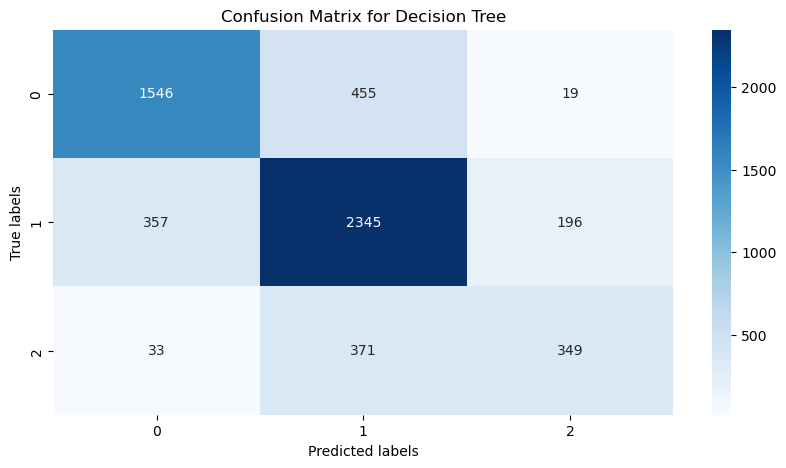

In [88]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Decision Tree')

In [89]:
results.append(["Decision Tree", accuracy_decision_tree, f1_decision_tree,training_duration])

### Random Forest

We next try to improve on our fine-tuned decision tree by employing a Random Forest. Aggregating the predictions of multiple decision trees to produce a final prediction may help produce more accurate predictions. Given the inherent variety in music data, having a model that can capture more complex boundaries while reducing the variance of the model and controlling overfitting is important. We also do not want the model to become too heavily affected by noise or unusual data points.

In [90]:
start_time = time.time()

param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None,1,2,4,5],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__class_weight': [None, 'balanced']
}

model = RandomForestClassifier(random_state=42)

pipeline_rf = Pipeline([
    ('feature_engineering', FeatureEngineeringTransformer()),
    ('resampler', resampler),
    ('model', model)
])

grid_search_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1
)


# fit the model
grid_search_rf.fit(X_train, y_train)

end_time = time.time()
training_duration = end_time - start_time
print(f"Total training time: {training_duration:.2f} seconds")


print("Best Parameters for RandomForest:", grid_search_rf.best_params_)
print("Best F1 Macro Score for RandomForest:", grid_search_rf.best_score_)


best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("\nClassification Report for RandomForestClassifier:")
print(classification_report(y_test, y_pred_rf))

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='macro')
print("F1 score:", f1_rf)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
Total training time: 186.31 seconds
Best Parameters for RandomForest: {'model__class_weight': None, 'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Best F1 Macro Score for RandomForest: 0.6849439838891791

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      2020
           1       0.75      0.78      0.76      2898
           2       0.54      0.50      0.52       753

    accuracy                           0.73      5671
   macro avg       0.69      0.68      0.68      5671
weighted avg       0.73      0.73      0.73      5671

Accuracy: 0.7339093634279669
F1 score: 0.6832637443098443


The Random Forest has an overall test accuracy of 72.2% which is slightly lower than the Decision Tree with the fine-tuned hyperparameters. The F1 score of 0.68 is comparable. 

That said, unlike with the Decision Tree, the Random Forest model predicted the correct label more times across all categories. In category 0, 1614/2126 = 75.9% of points were classified accurately. In category 1, this percentage was 2108/2785 = 75.7%, and in category 2 this percentage was 378/760 = 49.7%. Therefore, the classification accuracies improved for categories 0 and 2, but got slightly worse for category 1. Although the accuracy scores improved for category 0, the F1 score decreased slightly to 0.76. The F1 score also decreased slightly in category 1 to 0.75 and remained the same in category 2.

Although the increased accuracy in classifying category 2 appears to be a notable improvement, it seems that the F1 score did not change much. This suggests that there may have been improvements in other classes causing a higher accuracy for category 2 points whereas precision and recall for category 2 remains the same. The model's ability to handle category 2 songs does not seem to have changed from the prior model. As discussed previously, correctly identifying hit songs (category 2) is what the consumers and in particular the industry are likely looking for, and given the imbalance in the dataset this is a tricky task. We therefore aim to improve this further with the use of Boosting.

We note that the Random Forest model, similarly to our analysis of the Decision Tree model, once again struggles more with classifying songs that are in the next category. Overall, we see an improvement in predicting the most popular songs (category 2) when using a Random Forest compared to a Decision Tree, however there are still deficiencies. 

Text(0.5, 1.0, 'Confusion Matrix for Random Forest')

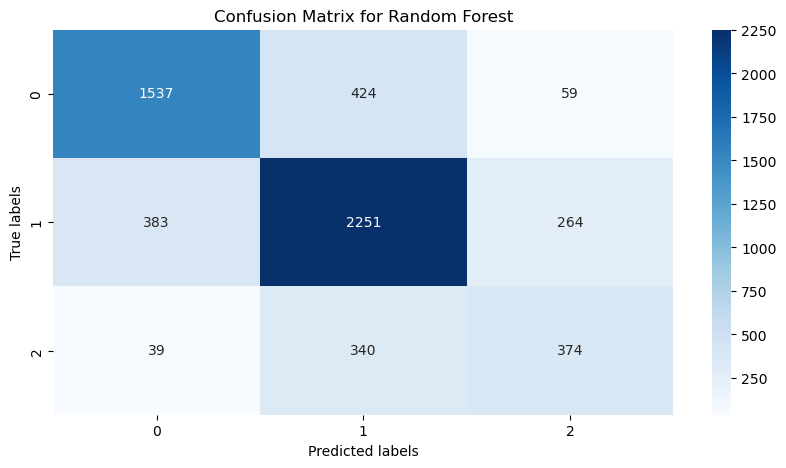

In [91]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')

In [92]:
results.append(["Random Forest", accuracy_rf, f1_rf, training_duration])

### Gradient Boosting

We explore the use of another ensemble method, boosting, to see if this approach yields a better result than the Random Forest.

In [93]:
start_time = time.time()

param_grid_gradient_boosting = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [5,10,20],
    'model__learning_rate': [0.01, 0.1]
}

model = GradientBoostingClassifier(random_state=42)

pipeline_gradient = Pipeline([
    ('feature_engineering', FeatureEngineeringTransformer()),
    # ('resampler', resampler), # no resampling needed for GradientBoosting
    ('model', model)
])

grid_search_gb = GridSearchCV(
    estimator=pipeline_gradient,
    param_grid=param_grid_gradient_boosting,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search_gb.fit(X_train, y_train)
end_time = time.time()
training_duration = end_time - start_time
print(f"Total training time: {training_duration:.2f} seconds")

print("Best Parameters for GradientBoosting:", grid_search_rf.best_params_)
print("Best F1 Macro Score for GradientBoosting:", grid_search_rf.best_score_)


best_gb = grid_search_gb.best_estimator_
y_pred_gb= best_gb.predict(X_test)
print("\nClassification Report for GradientBoosting:")
print(classification_report(y_test, y_pred_gb))

accuracy_gb = accuracy_score(y_test, y_pred_gb)

f1_gb = f1_score(y_test, y_pred_gb,  average='macro')
print("F1 score:", f1_gb)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Total training time: 896.64 seconds
Best Parameters for GradientBoosting: {'model__class_weight': None, 'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Best F1 Macro Score for GradientBoosting: 0.6849439838891791

Classification Report for GradientBoosting:
              precision    recall  f1-score   support

           0       0.80      0.75      0.78      2020
           1       0.73      0.86      0.79      2898
           2       0.78      0.42      0.54       753

    accuracy                           0.76      5671
   macro avg       0.77      0.68      0.70      5671
weighted avg       0.77      0.76      0.75      5671

F1 score: 0.7044050155754916


When using Gradient Boosting, the resulting model has a test accuracy of 74.1% which is an improvement from both the Decision Tree with fine-tuned hyperparameters and the Random Forest. The macro average F-1 score is 0.7, which also an improvement from the prior models.

Looking at the Confusion Matrix, we see that, similarly to the Random Forest model, the Gradient Boosting model predicted the correct label more times than not across all categories. In category 0, the F1 score was 0.78. In category 1, this number was 0.76, and in category 2 this was 0.55. We can see that once again there was a similar performance for categories 0 and 1, with a poorer performance for category 2. Compared to the Random Forest model, the F1 scores improved across all the categories. 

Although this Gradient Boosting model performs has a lower accuracy for predicting category 2 songs than the Random Forest, it has a higher F1 score. This suggests that although the Gradient Boosting model had fewer correct classifications, it did a better job at avoiding false positives and false negatives. Therefore, the improved F1 score indicates it was better at identifying true instances of category 2 songs.  

Despite fine-tuning the hyperparameters and using different models, the nuances in category 1 hit songs are difficult to predict. This is the biggest challenge at increasing the model's overall accuracy.

Text(0.5, 1.0, 'Confusion Matrix for Gradient Boosting')

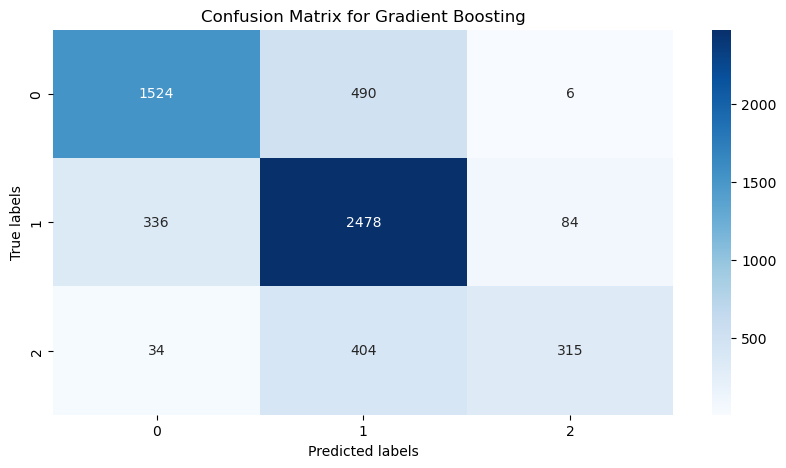

In [94]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Gradient Boosting')

In [95]:
results.append(["Gradient Boosting", accuracy_gb, f1_gb, training_duration])   

### XGBoost

We also consider XGBoost to see if the model performance improves any further.

In [96]:
start_time = time.time()
param_grid_xgb = {
    'model__n_estimators': [250,300,400],
    'model__max_depth': [None,5,10,],
    'model__learning_rate': [ 0.1,0.5],
    'model__subsample': [0.5,0.7, 1.0],
    'model__colsample_bytree': [0.5,0.7, 1.0],
}


model = XGBClassifier(use_label_encoder=False,
                      eval_metric='mlogloss', random_state=42)

pipeline_xgb = Pipeline([
    ('feature_engineering', FeatureEngineeringTransformer()),
    # ('resampler', resampler), # no resampling needed for XGBoost
    ('model', model)
])
grid_search_xgb = GridSearchCV(
    estimator=pipeline_xgb,
    param_grid=param_grid_xgb,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1
)


grid_search_xgb.fit(X_train, y_train)
end_time = time.time()
training_duration = end_time - start_time
print(f"Total training time: {training_duration:.2f} seconds")

print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best F1 Macro Score for XGBoost:", grid_search_xgb.best_score_)

best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
print("\nClassification Report for XGBoostClassifier:")
print(classification_report(y_test, y_pred_xgb))

f1_xgb = f1_score(y_test, y_pred_xgb, average='macro')
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", accuracy_xgb)
print("F1 score:", f1_xgb)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:43:52] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:43:52] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:43:52] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warning

Total training time: 334.91 seconds
Best Parameters for XGBoost: {'model__colsample_bytree': 0.5, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 250, 'model__subsample': 1.0}
Best F1 Macro Score for XGBoost: 0.7043818947286916

Classification Report for XGBoostClassifier:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      2020
           1       0.74      0.86      0.79      2898
           2       0.77      0.40      0.53       753

    accuracy                           0.76      5671
   macro avg       0.77      0.67      0.70      5671
weighted avg       0.76      0.76      0.75      5671

Accuracy: 0.7608887321460059
F1 score: 0.7004549686153645


As we can see from the outputs, using XGBoost does not appear to offer any advantages over Gradient Boosting. The F1 scores are slightly decreased, and the accuracy is almost the same. Therefore, we decide to use the Gradient Boosting model. 

Text(0.5, 1.0, 'Confusion Matrix for XGBoost')

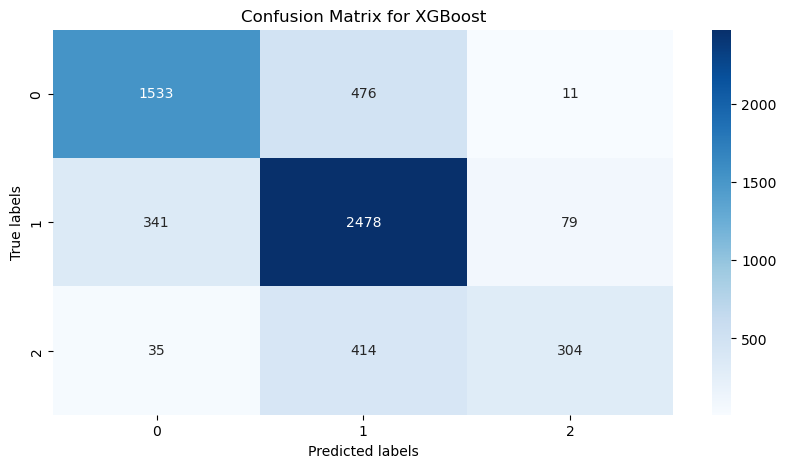

In [97]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for XGBoost')

In [98]:
results.append(["XGBoost", accuracy_xgb, f1_xgb, training_duration])

### Blending and Stacking

In [99]:
from sklearn.ensemble import VotingClassifier

start_time = time.time()
# remove "model__" prefix from best parameters if not it fails
xgb_params = {key.replace("model__", ""): value for key, value in grid_search_xgb.best_params_.items()}
gb_params = {key.replace("model__", ""): value for key,
             value in grid_search_gb.best_params_.items()}
dt_params = {key.replace("model__", ""): value for key,
             value in grid_search.best_params_.items()}

# models
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    **xgb_params
)
gradient_model = GradientBoostingClassifier(random_state=42, **gb_params)
decision_tree_model = DecisionTreeClassifier(random_state=42, **dt_params)

blended_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('gradient', gradient_model),
        ('decision_tree', decision_tree_model),
    ],
    voting='hard'  
)

blended_model.fit(X_train, y_train)

end_time = time.time()
training_duration_blending = end_time - start_time

y_pred_blended = blended_model.predict(X_test)
print("\nClassification Report for Blended Model:")
print(classification_report(y_test, y_pred_blended))

accuracy_blended = accuracy_score(y_test, y_pred_blended)
print("Accuracy:", accuracy_blended)

f1_blended = f1_score(y_test, y_pred_blended, average='macro')
print("F1 Macro Score:", f1_blended)

/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:49:27] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report for Blended Model:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      2020
           1       0.74      0.86      0.79      2898
           2       0.79      0.41      0.54       753

    accuracy                           0.76      5671
   macro avg       0.78      0.67      0.70      5671
weighted avg       0.77      0.76      0.75      5671

Accuracy: 0.763181096808323
F1 Macro Score: 0.7036608812890588


In [100]:
from sklearn.ensemble import StackingClassifier

start_time = time.time()
base_estimators = [
    ('xgb', xgb_model),
    ('gradient', gradient_model),
    ('decision_tree', decision_tree_model),
]

meta_model = LogisticRegression(random_state=42)

stacked_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_model,
    cv=cv,  
    n_jobs=-1
)

stacked_model.fit(X_train, y_train)

end_time = time.time()
training_duration_stacking = end_time - start_time

y_pred_stacked = stacked_model.predict(X_test)
print("\nClassification Report for Stacked Model:")
print(classification_report(y_test, y_pred_stacked))

accuracy_stacked = accuracy_score(y_test, y_pred_stacked)
print("Accuracy:", accuracy_stacked)

f1_stacked = f1_score(y_test, y_pred_blended, average='macro')
print("F1 Macro Score:", f1_stacked)

/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:50:01] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[16:50:35] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[16:50:35] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[16:50:35] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Classification Report for Stacked Model:
              precision    recall  f1-score   support

           0       0.81      0.76      0.78      2020
           1       0.74      0.86      0.79      2898
           2       0.78      0.42      0.55       753

    accuracy                           0.76      5671
   macro avg       0.77      0.68      0.71      5671
weighted avg       0.77      0.76      0.76      5671

Accuracy: 0.7637101040380885
F1 Macro Score: 0.7036608812890588


In [101]:
results.append(["Blended Model", accuracy_blended, f1_blended, training_duration_blending])
results.append(["Stacked Model", accuracy_stacked, f1_stacked, training_duration_stacking])

## Results

In [102]:
print("Results:")
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 score", "Training Duration (s)"])
results_df

Results:


,Model,Accuracy,F1 score,Training Duration (s)
0,Decision Tree,0.747664,0.694790,53.095037
1,Random Forest,0.733909,0.683264,186.309490
2,Gradient Boosting,0.761241,0.704405,896.644416
3,XGBoost,0.760889,0.700455,334.913907
4,Blended Model,0.763181,0.703661,33.686524
5,Stacked Model,0.763710,0.703661,58.738828


Like we discussed above, the Gradient Boosting model has the best F1 and accuracy scores (without Stacked model) after testing numerous models and hyperparameters. In particular, it does the best compared to the other models at identifying instances false positives and false negatives which are both important in this context. 

Despite efforts to increase the accuracy of predicting category 2 (the most popular songs) such as utilizing different models and using SMOTE as part of the pipeline to address the data imbalance, the model still struggled the most with predicting which songs would be hits. Nonetheless, the model performed better at differentiating songs in categories 0 and 1.

It therefore seems that, from our analysis, there are certain features or traits of songs that make some more popular than others although it is challenging to differentiate between neighbouring categories. 

#### Feature importance

From the permutation plot below, we can analyze the most important features in our chosen model. By far the most important factor is the Artist themself. This is not surprising, as once an artist gains a following and becomes recognized, their subsequent tracks are more likely to be anticipated and listened to by consumers. For a lot of big artists such a Taylor Swift, newly released music becomes popular in an instant, even if the style of their new music deviates slightly from existing work. This also suggests that it may be hard for new artists to "break in", and that generating a consistent audience is important. This hypothesis is backed up by the number of zero popularity score tracks on the platform which could be attributed to artists trying to find an audience.

Genre also appears to play a role in permutation importance - by its name, it's not surprising that pop has the most popular songs. It could be the case that some genres are more approachable and wide reaching than others.

We note that `release_year` is also an important feature. Trends in music are always changing, and what is popular changes with time. This feature being important suggests that when the song was released is relevant to how popular a certain song is today.

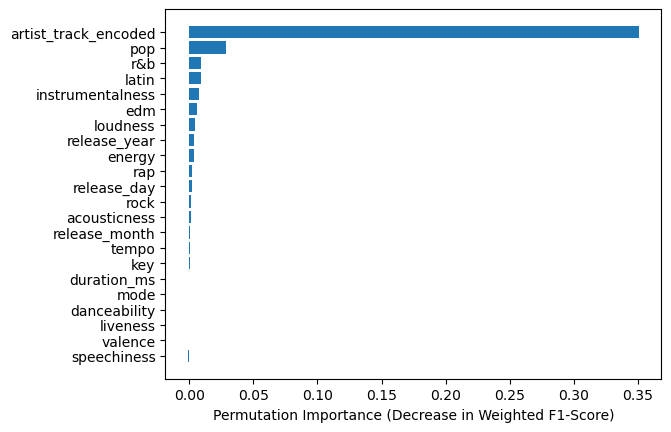

In [103]:
perm_importance = permutation_importance(best_gb, X_test, y_test, scoring='f1_macro', n_repeats=10, random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance (Decrease in Weighted F1-Score)")
plt.show()

# to do: include plot title and change axis name (should be macro F-1 score not weighted)


### Limitations and future directions

It is easier than ever to upload your own music, as well as to find new artists who may not be as popular in the mainstream. Although there are certain artists who are still the most popular, the music industry in many ways seems to be moving towards personalized recommendations. Even 10 years ago, the idea of a top chart and listening to the most popular songs was very common. Now, consumers are choosing platforms such as Spotify which are able to generate extremely personalized algorithms. 

Although identifying a song's popularity is an important task, analyzing music in this way has the limitation of not accounting for personal preferences. There may be trends in this variation across regions and countries, but ultimately it may come down to personal preference. It may be the case that trying to predict the most popular songs overall is too broad of a task. Perhaps it might make sense to look within certain geographies or music genres. This approach may make better sense from a music data perspective as songs from the same genre might share similarities, but also from an industry and consumer point of view. Industries can promote music in a more targeted manner to consumers.  

Furthermore, the dataset that our algorithm was trained on was using Spotify data, which captures a fraction of the demographic who listen to music. It may be the case that users in different countries or groups prefer using different streaming services, or even prefer to buy music. This means that there may be some data about music popularity that is not captured in the Spotify dataset. In the future, we could consider using data from additional sources. 

In practice, Spotify's algorithm - which uses the same metrics that we used in our analysis - is used for recommending songs and helping customers identify songs that they might enjoy. Like identifying popular music, connecting music to listeners is important for both industry and consumers, but does so in a different way. It may be the case that the metrics identified for Spotify's algorithm are more suited to recommendation algorithms that necessarily predicting popularity. Future work in this area could be to analyze music more closely, and to potentially identify metadata that would be more useful to prediction tasks. In the final part of our project, we will create our own version of a recommendation algorithm.

## Recommendation system

As the second part of our project, we wanted to implement a song recommendation system. The idea is simple : based on an array of songs (i.e songs that you like), recommends similar song(s) that we might like. 

For that, we'll compare two different clustering method (K-meands and content-based filtering)

TODO: Improve that

In [104]:
# fresh start (we don't need our previous preprocessing steps)
file_path = '../data/processed_spotify_songs.csv'
data = pd.read_csv(file_path)

In [105]:
cluster_features = [
    'danceability', 'energy', 'key', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence',
    'tempo', 'artist_track_encoded', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock'
]

scaler = StandardScaler()
normalized_features = scaler.fit_transform(data[cluster_features])

/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-p

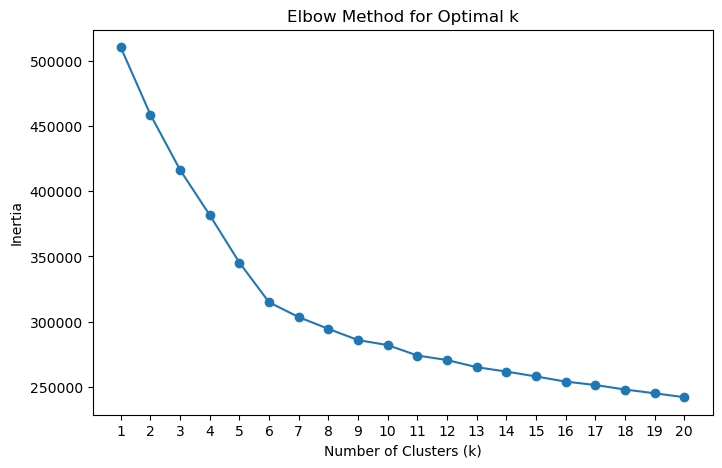

In [106]:
# Implementing the elbow method to find the optimal number of clusters

inertias = []
max_k = 20

for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_features)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, max_k + 1), inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.xticks(range(1, max_k + 1))
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


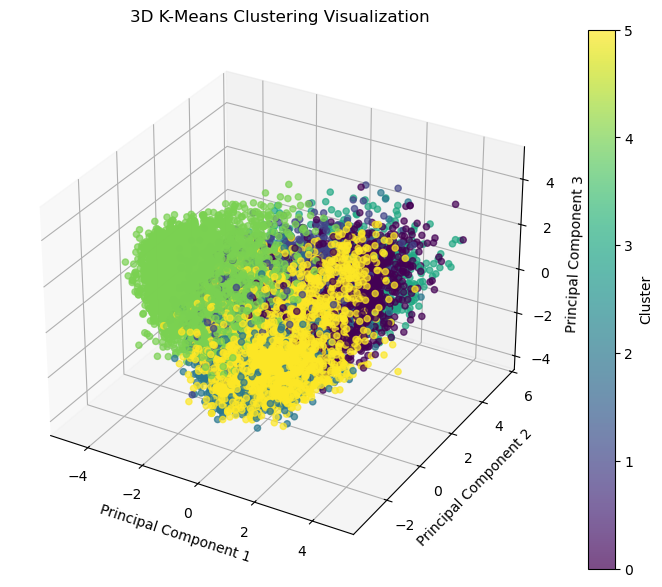

In [107]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

optimal_k = 6

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data_cluster = data.copy()
data_cluster['Cluster'] = kmeans.fit_predict(normalized_features)

pca = PCA(n_components=3)
reduced_features = pca.fit_transform(normalized_features)

# 3d plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
                     c=data_cluster['Cluster'], cmap='viridis', alpha=0.7)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D K-Means Clustering Visualization')

color_bar = fig.colorbar(scatter, ax=ax, label='Cluster')
plt.show()

Let us now try to interpret these clusters. Our hypothesis is that it clusters based off of genre, so let's plot that and compare.

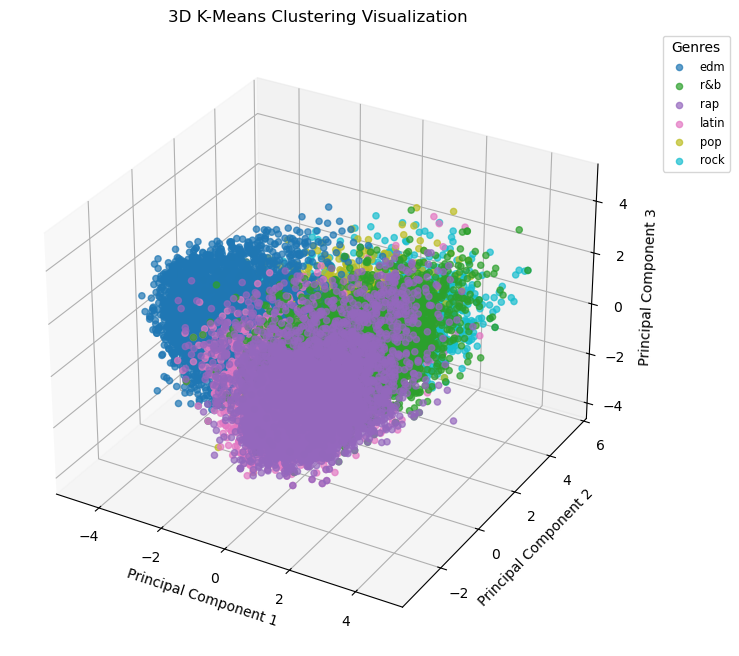

In [109]:

# Assign a unique color and marker for each genre
genres = ['edm', 'r&b', 'rap', 'latin', 'pop', 'rock']
colors = plt.cm.tab10(np.linspace(0, 1, len(genres)))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for genre, color in zip(genres, colors):
    genre_data = data_cluster[data_cluster[genre] == 1]
    scatter = ax.scatter(
        reduced_features[genre_data.index, 0],
        reduced_features[genre_data.index, 1],
        reduced_features[genre_data.index, 2],
        label=genre,  
        color=color,
        alpha=0.7
    )

# Add labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D K-Means Clustering Visualization')
ax.legend(title="Genres", loc='upper left',
          bbox_to_anchor=(1.05, 1), fontsize='small')
plt.show()

Comparing the two plots, we can see that the clusters are most likely based off of genre.

In [110]:
def recommend_songs_k_means(input_indices, data_cluster, normalized_features, num_recommendations=1):

    cluster_features = data_cluster['Cluster'].values.reshape(-1, 1)
    combined_features = np.hstack([normalized_features, cluster_features])

    input_song_features = combined_features[input_indices]

    similarities = cosine_similarity(input_song_features, combined_features)
    similarities = np.mean(similarities, axis=0)

    for idx in input_indices:   
        similarities[idx] = -1
        
    recommended_song_indices = np.argsort(similarities)[::-1][:num_recommendations]

    return data_cluster.iloc[recommended_song_indices]

In [111]:
input_indices = np.random.choice(data_cluster.shape[0], 3, replace=False)
print("Some of the input songs' features:")
data_cluster.iloc[input_indices][['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock', 'Cluster']]

Some of the input songs' features:


,track_artist,playlist_subgenre,release_year,edm,r&b,rap,latin,pop,rock,Cluster
11265,AronChupa,"dance pop, electro house",2019,1,0,0,0,1,0,1
6892,Clean Bandit,electropop,2018,0,0,0,0,1,0,1
24280,_tag,hip hop,2019,0,0,1,0,0,0,5


In [112]:
recommendations = recommend_songs_k_means(input_indices, data_cluster, normalized_features)
print("Recommended Songs:")
recommendations[['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock', 'Cluster']]

Recommended Songs:


,track_artist,playlist_subgenre,release_year,edm,r&b,rap,latin,pop,rock,Cluster
24329,Twenty One Pilots,"electropop, indie poptimism, pop edm",2016,1,0,0,0,1,0,1


#### b. Content-based filtering

In [113]:
## The features we want to influence the recommendation system
features = [
        'danceability', 'energy', 'key', 'loudness', 'speechiness',
        'acousticness', 'instrumentalness', 'liveness', 'valence',
        'tempo', 'artist_track_encoded', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock'
    ]

In [114]:
def recommend_songs_content_filter(input_indices, data, features, num_recommendations=1):
    feature_matrix = data[features].values
    input_features = feature_matrix[input_indices]
    avg_features = np.mean(input_features, axis=0).reshape(1, -1)
    
    similarities = cosine_similarity(avg_features, feature_matrix).flatten()
    similar_indices = np.argsort(similarities)[::-1]
    similar_indices = [idx for idx in similar_indices if idx not in input_indices][:num_recommendations]
    
    return data.iloc[similar_indices]

In [115]:
input_indices = np.random.choice(data.shape[0], 3, replace=False)
print("Some of the input songs' features:")
data.iloc[input_indices][['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock']]

Some of the input songs' features:


,track_artist,playlist_subgenre,release_year,edm,r&b,rap,latin,pop,rock
28202,ØMG,dance pop,2020,0,0,0,0,1,0
12002,Revolution Saints,hard rock,2019,0,0,0,0,0,1
18509,Destroyer,"dance pop, hip pop",2011,0,1,0,0,1,0


In [116]:
recommendations = recommend_songs_content_filter(input_indices, data, features)
print("Recommended Songs:")
recommendations[['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock']]

Recommended Songs:


,track_artist,playlist_subgenre,release_year,edm,r&b,rap,latin,pop,rock
17600,Tujamo,post-teen pop,2017,0,0,0,0,1,0


Let us now figure out which features influence the recommendation system the most using a feature sensitivity analysis.

In [117]:
def analyze_feature_influence(input_songs, data, features, num_recommendations=1):

    ## Same as before for the next lines
    feature_matrix = data[features].values
    input_features = feature_matrix[input_songs]
    avg_features = np.mean(input_features, axis=0).reshape(1, -1)
    similarities = cosine_similarity(avg_features, feature_matrix).flatten()
    original_similar_indices = np.argsort(similarities)[::-1][:num_recommendations]

    feature_influence = []
    for i, feature in enumerate(features):
        perturbed_features = avg_features.copy()
        perturbed_features[0, i] += np.std(feature_matrix[:, i])

        new_similarities = cosine_similarity(perturbed_features, feature_matrix).flatten()
        new_similar_indices = np.argsort(new_similarities)[::-1][:num_recommendations]

        change_in_rank = len(set(original_similar_indices) - set(new_similar_indices))
        feature_influence.append((feature, change_in_rank))

    feature_influence.sort(key=lambda x: x[1], reverse=True)
    return pd.DataFrame(feature_influence, columns=["Feature", "Change in Rank"])

In [118]:
## We use the same features and input indices as before
feature_influence = analyze_feature_influence(input_indices, data, features, num_recommendations=5)
print(feature_influence)

                 Feature  Change in Rank
0                    key               5
1   artist_track_encoded               5
2                  tempo               3
3           release_year               3
4                   rock               3
5                valence               2
6                 energy               1
7           acousticness               1
8       instrumentalness               1
9               liveness               1
10                   r&b               1
11          danceability               0
12              loudness               0
13           speechiness               0
14                   edm               0
15                   rap               0
16                 latin               0
17                   pop               0


So we notice in this model that the genre is no longer the most important, but rather having similar audio features (key, energy, tempo etc.) and artist. 

However, we still notice that latin is pointed out as a relevant feature which might be coming from potential imbalance of the genres amongst our dataset. Let's check for that.

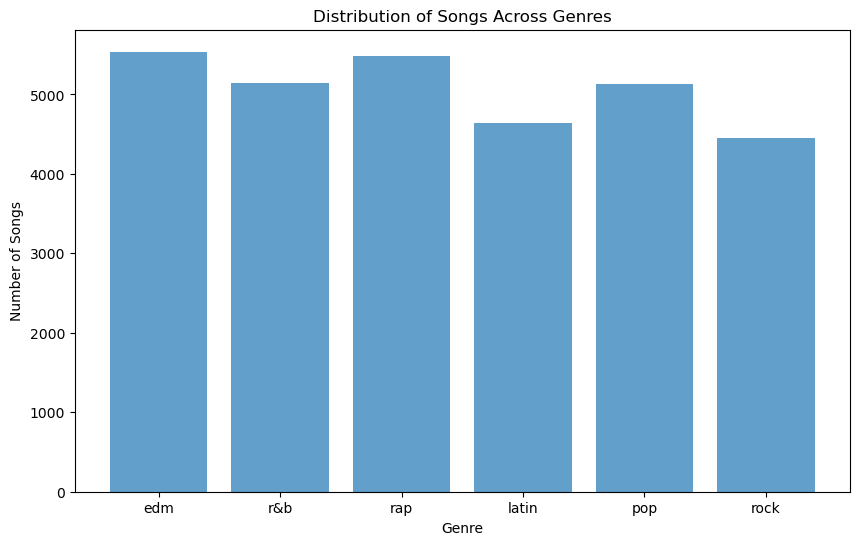

In [119]:
plt.figure(figsize=(10, 6))
genres = ['edm', 'r&b', 'rap', 'latin', 'pop', 'rock']

genre_counts = [data[genre].sum() for genre in genres]
plt.bar(genres, genre_counts, alpha=0.7)
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.title('Distribution of Songs Across Genres')
plt.show()

From the plot above, we don't notice particularly strong imbalance between the genres, especially not in favour of the latin genre... Our second hypothesis for why the latin genre tends to come out as an important feature is that it might be a much more distinct genre in terms of audio features (which we showed are the most influent features for the recommendation system) and thus it stands out as an important feature due to this correlation.

Furthermore, we remove 'loudness', 'speechiness', 'instrumentalness' from the analysis, because from above, they have an importance weight of 0.

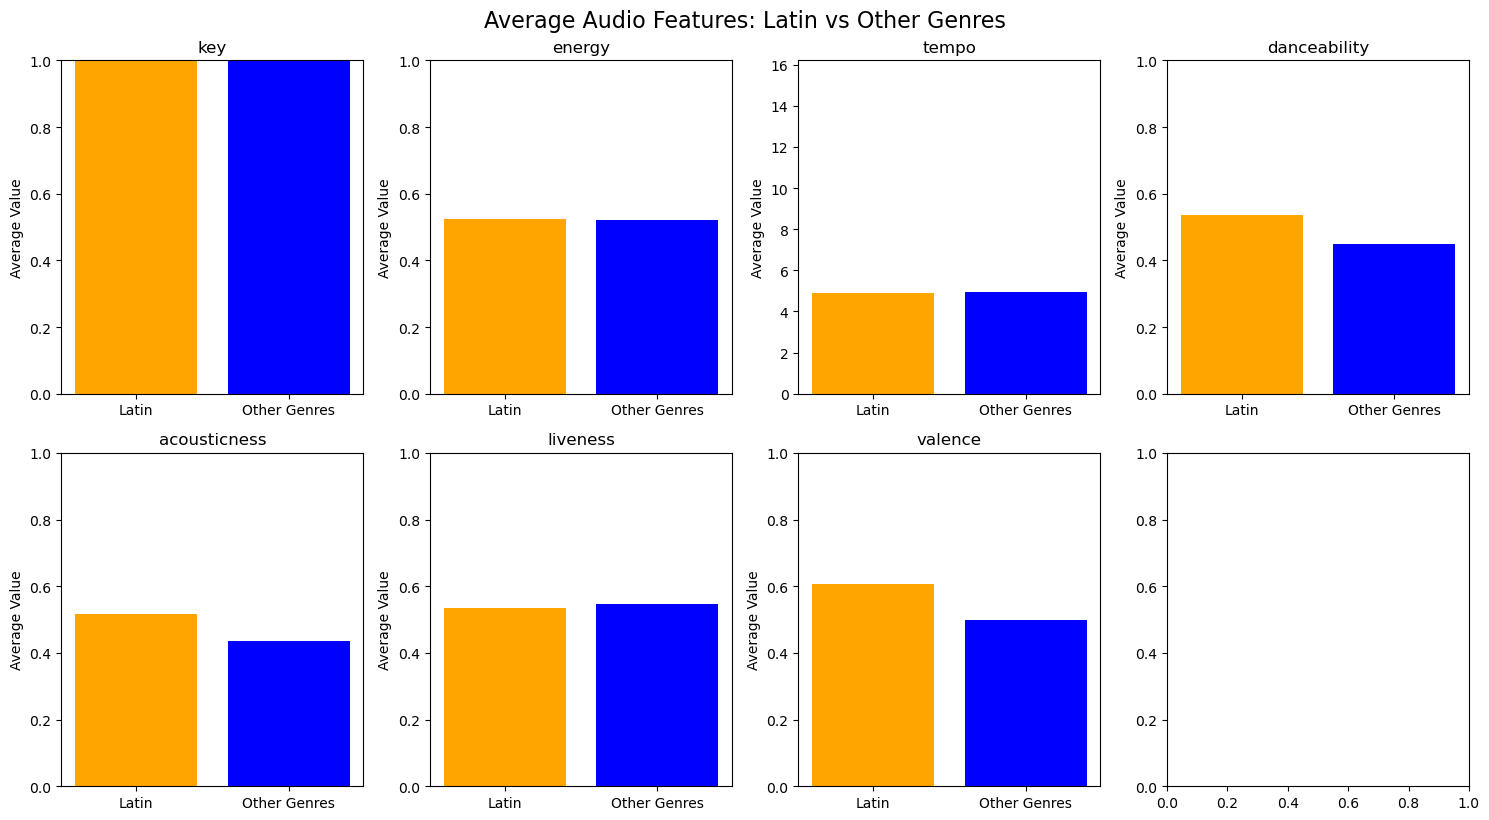

In [120]:
audio_features = [
    'key', 'energy', 'tempo', 'danceability', 'acousticness',
    'liveness', 'valence'
]

latin_avg = data[data['latin'] == 1][audio_features].mean()
non_latin_avg = data[data['latin'] == 0][audio_features].mean()

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()
for i, feature in enumerate(audio_features):
    axes[i].bar(['Latin', 'Other Genres'], [latin_avg[feature], non_latin_avg[feature]], color=['orange', 'blue'])
    axes[i].set_title(feature)
    axes[i].set_ylabel('Average Value')
    axes[i].set_ylim(0, 1 if feature != 'tempo' else data[feature].max() + 10)
plt.tight_layout()
plt.suptitle('Average Audio Features: Latin vs Other Genres', y=1.02, fontsize=16)
plt.show()

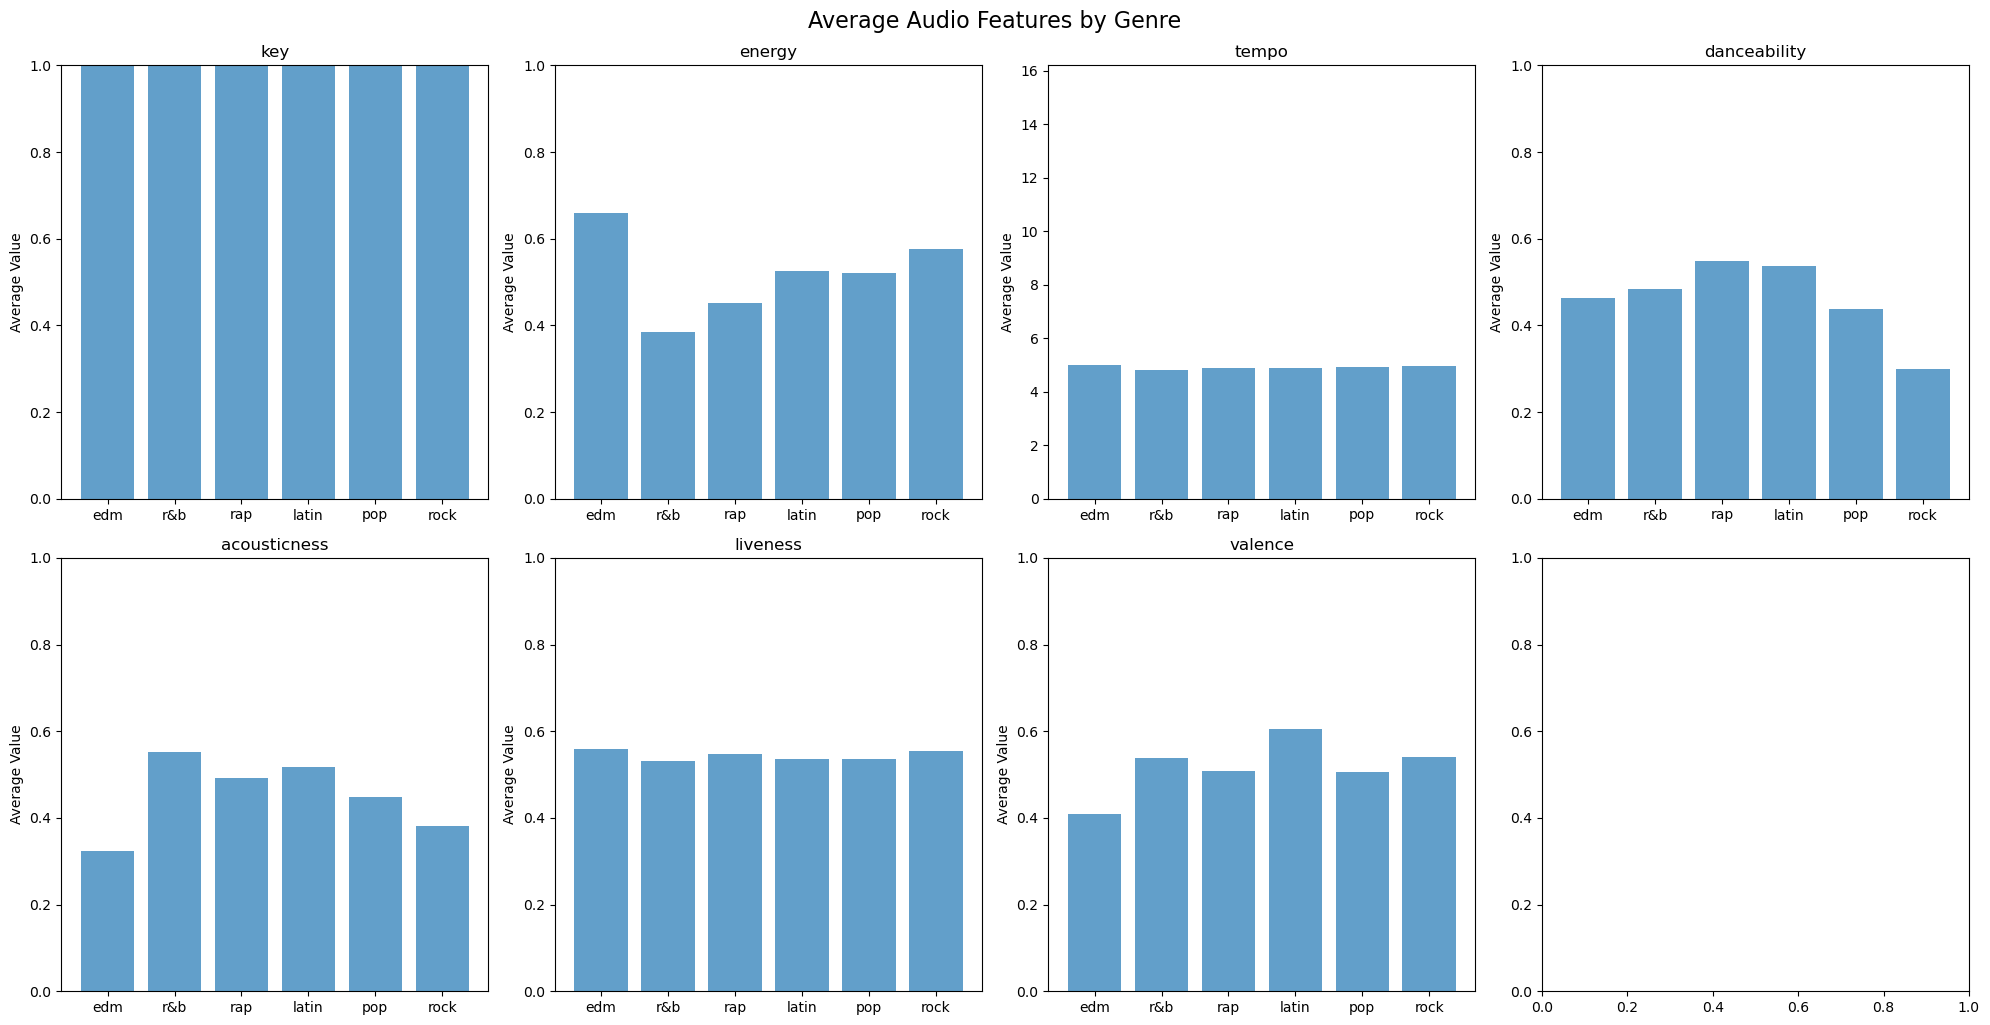

In [121]:
audio_features = [
    'key', 'energy', 'tempo', 'danceability', 'acousticness',
    'liveness', 'valence'
]
genres = ['edm', 'r&b', 'rap', 'latin', 'pop', 'rock']


genre_averages = {genre: data[data[genre] == 1][audio_features].mean() for genre in genres}
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i, feature in enumerate(audio_features):
    feature_averages = [genre_averages[genre][feature] for genre in genres]
    axes[i].bar(genres, feature_averages, alpha=0.7)
    axes[i].set_title(feature)
    axes[i].set_ylabel('Average Value')
    axes[i].set_ylim(0, 1 if feature != 'tempo' else data[feature].max() + 10)
plt.tight_layout()
plt.suptitle('Average Audio Features by Genre', y=1.02, fontsize=16)
plt.show()

So we notice indeed that our second hypothesis might be correct, as the latin genre is more distinct in terms of danceability, acousticness and valence than when averaging the other genres! However, it does not consistently stand out and is still not the highest or lowest in terms of danceability and acousticness. Overall, it is a mix of these features that makes the latin genre stand out.

#### e. Comparison of models

In [122]:
input_indices = np.random.choice(data.shape[0], 3, replace=False)
print("Some of the input songs' features:")
data.iloc[input_indices][['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock']]

Some of the input songs' features:


,track_artist,playlist_subgenre,release_year,edm,r&b,rap,latin,pop,rock
24186,Rae Sremmurd,electropop,2016,0,0,0,0,1,0
20990,N.W.A.,gangster rap,1988,0,0,1,0,0,0
5741,Crossfade,hard rock,2004,0,0,0,0,0,1


In [123]:
data_cluster.iloc[input_indices][['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock', 'Cluster']]

,track_artist,playlist_subgenre,release_year,edm,r&b,rap,latin,pop,rock,Cluster
24186,Rae Sremmurd,electropop,2016,0,0,0,0,1,0,1
20990,N.W.A.,gangster rap,1988,0,0,1,0,0,0,5
5741,Crossfade,hard rock,2004,0,0,0,0,0,1,3


In [124]:
print('\n a. K-means clustering \n')
recommendations = recommend_songs_k_means(input_indices, data_cluster, normalized_features)
recommendations[['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock', 'Cluster']]


 a. K-means clustering 



,track_artist,playlist_subgenre,release_year,edm,r&b,rap,latin,pop,rock,Cluster
23946,OutKast,"hip hop, southern hip hop",2003,0,0,1,0,0,0,5


In [125]:
print('\n b. Content-based filtering \n')
recommendations = recommend_songs_content_filter(input_indices, data, features)
recommendations[['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock']]


 b. Content-based filtering 



,track_artist,playlist_subgenre,release_year,edm,r&b,rap,latin,pop,rock
25304,Savoir Adore,indie poptimism,2012,0,0,0,0,1,0
